In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from tqdm import tqdm
import os
import ast
import pickle as pkl
import time
import dash
from abc import ABC
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarasabbagha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yarasabbagha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importing the data

In [172]:
DATA_FOLDER = 'data/MovieSummaries/'
ADDITIONAL_FOLDER = 'data/AdditionalData/'

In [173]:
# reading a txt file and convert it to a dataframe
def read_txt(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [174]:
# importing the data
plots = pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', header=None, sep="\t")
movies = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', header=None, sep="\t")
characters = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', header=None, sep="\t")
names = pd.read_csv(DATA_FOLDER + 'name.clusters.txt', header=None, sep="\t")
tvtropes = pd.read_csv(DATA_FOLDER + 'tvtropes.clusters.txt', header=None, sep="\t")

In [175]:
# renaming columns the plots dataframe
plots.columns = ['wikipedia_movie_id', 'plot']

`movies` data

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [176]:
# renaming the movie dataframe columns
movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'name', 'release_date', 'revenue', 'runtime', 'languages',
                  'countries', 'genres']

`characters` data:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [177]:
# fixing the character columns
characters.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'date_of_birth',
                      'gender', 'height', 'ethnicity', 'name', 'age_at_release', 'freebase_character_map_id',
                      'freebase_character_id', 'freebase_actor_id']

# Data preprocessing

In [178]:
revenue_nans = movies[movies['revenue'].isna()]["wikipedia_movie_id"]
print('Number of movies without revenue data: ', revenue_nans.shape[0])

Number of movies without revenue data:  73340


### Completing missing revenue data

In [179]:
# reading the scraped dataset
imdb_movies = pd.read_csv(ADDITIONAL_FOLDER + 'imdb_scraped_dataset.csv')
imdb_movies.head(3)

,wikipedia_movie_id,name,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,release_year
0,975900,Ghosts of Mars,14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001.0
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas,2000.0
2,28463795,Brun bitter,NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen,1988.0


In [180]:
# computing number of movies without global revenue data in the imdb dataset
global_revenue_nans = imdb_movies[imdb_movies['global_revenue'].isna()]["wikipedia_movie_id"]
print('Number of movies without global revenue data: ', global_revenue_nans.shape[0])

Number of movies without global revenue data:  64912


We have less missing revenue data in the scraped data

In [181]:
# calculating number of movies that have missing revenue in the original dataset but don't have missing revenue in the imdb dataset
(~global_revenue_nans.isin(revenue_nans)).value_counts()

wikipedia_movie_id
False    63468
True      1444
Name: count, dtype: int64

1444 scraped movies have revenue informations not present in out original dataset. We can thus complete our revenue data with them.

### Completting missing date data

In [182]:
imdb_movies.drop(columns=['name'], inplace=True)
imdb_movies["imdb_release_date"] = pd.to_datetime(imdb_movies["release_year"], format="%Y")
movies_augmented = pd.merge(movies, imdb_movies, on="wikipedia_movie_id")
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,release_year,imdb_release_date
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001.0,2001-01-01
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas,2000.0,2000-01-01
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen,1988.0,1988-01-01


Similarly to the previous part, we see that the scraping was able to retrieve 1711 release years that were missing in our original data. We can similarly complete them.

In [183]:
missing_dates = movies_augmented[movies_augmented['release_date'].isna()].index.values

In [184]:
# filling the missing dates with the imdb dates
movies_augmented.loc[missing_dates, "release_date"] = movies_augmented.loc[missing_dates, "imdb_release_date"]

# replace NaT with nans
movies_augmented["release_date"].where(movies_augmented["release_date"].notnull(), None, inplace=True)
movies_augmented.drop(columns=['release_year', 'imdb_release_date'], inplace=True)
movies_augmented.loc[missing_dates, "release_date"].head(3)

15    1941-01-01 00:00:00
74    1927-01-01 00:00:00
81    1977-01-01 00:00:00
Name: release_date, dtype: object

We can also create a year feature in our dataset

In [185]:
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen


In [186]:
"""extracting the year from the release date feature"""

# extracting the years from the release date feature
movie_with_date = movies_augmented[-movies_augmented["release_date"].isna()].copy(deep=True)
dates = movie_with_date["release_date"]
date_years = dates.astype(str).str.extract(r'(\d{4})')

# adding an index column & renaiming the date_years columns
date_years["index"] = date_years.index
date_years.columns = ["year", "index"]

# adding an index column to the movies_augmented dataframe
movies_augmented["index"] = movies_augmented.index

# merging the movies_augmented and date_years dataframes on the index column
merged = pd.merge(movies_augmented, date_years, on="index", how="left")
merged.drop(columns=["index"], inplace=True)
movies_augmented = merged.copy(deep=True)
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas,2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen,1988


In [187]:
# filling the missing dates with the imdb dates
missing_revenue = movies_augmented[movies_augmented['revenue'].isna()].index.values
movies_augmented.loc[missing_revenue, "revenue"] = movies_augmented.loc[missing_revenue, "global_revenue"]
movies_augmented.loc[missing_revenue, "revenue"].head(3)

1   NaN
2   NaN
3   NaN
Name: revenue, dtype: float64

### Removing useless data
We shouldn't consider movies with no revenue data, no valid date or no valid ratingwe shouldn't consider movies with no revenue data, no valid date or no valid rating

In [188]:
#droping missing revenue, date & rating datapoints
revenue_nans_filter = movies_augmented['revenue'].isna()
release_date_nans_filter = movies_augmented['release_date'].isna()
rating_nans_filter = movies_augmented['rating_score'].isna()

movies_augmented = movies_augmented[~(revenue_nans_filter | release_date_nans_filter | rating_nans_filter)].copy(
    deep=True)

# dropping the global_revenue column
movies_augmented.drop(columns=["global_revenue"], inplace=True)

# checking we removed all the useless datapoints
missing_revenue = movies_augmented["revenue"].isna().sum()
missing_dates = movies_augmented["release_date"].isna().sum()
missing_rating = movies_augmented["rating_score"].isna().sum()

print(f"Missing release date datapoints: {missing_revenue}")
print(f"Missing rating datapoints: {missing_dates}")
print(f"Missing revenue datapoints: {missing_rating}")

Missing release date datapoints: 0
Missing rating datapoints: 0
Missing revenue datapoints: 0


In [189]:
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,NaN,NaN,6.8,2300.0,NaN,Henry King,1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,10161099.0,64933.0,7.5,31000.0,NaN,Kenneth Branagh,1989


In [190]:
movies_augmented.shape

(17766, 17)

We are left with close to 18000 clean datapoints, which is a lot less than the total numbers of movies we had at the beginning. But this is necessary to correctly define the next analysis steps we will conduct.

In [191]:
# converting years to floats & defining a new dataframe
movies = movies_augmented.copy(deep=True)
movies["year"] = movies["year"].astype(float)

## Taking care of inflation

Comparing movie revenues across different periods of time is not relevant as the value of the USD has varied inbetween. This calls for taking inflation into account and adjusting revenues across all time periods on a single reference date.

In [192]:
# inflation data from:
# https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/
us_inflation = pd.read_csv(ADDITIONAL_FOLDER + "US_yearly_inflation.csv")
us_yearly_inflation = us_inflation[["Year", "Avg-Avg"]].fillna(0)
us_yearly_inflation.rename(columns={"Year": "year", "Avg-Avg": "avg_avg"}, inplace=True)
us_yearly_inflation.head(3)

,year,avg_avg
0,1913,0.0
1,1914,1.0
2,1915,1.0


In [193]:
# the 1897 datapoint needs to be removed as we have no inflation data for before 1913
movies = movies[movies["year"] >= 1913]

In [194]:
us_yearly_inflation.head(5)

,year,avg_avg
0,1913,0.0
1,1914,1.0
2,1915,1.0
3,1916,7.9
4,1917,17.4


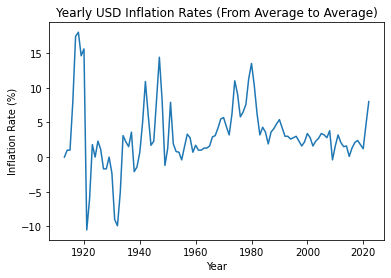

In [195]:
# plotting the yearly USD Inflation Rates
x_values = us_yearly_inflation['year'].values
y_values = us_yearly_inflation['avg_avg'].values

plt.plot(x_values, y_values)
plt.title("Yearly USD Inflation Rates (From Average to Average)")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.grid(False)
plt.show()

In [196]:
prices = [1]  # we set the initial price as a reference

# Calculate prices based on inflation rates
for index, row in us_yearly_inflation.iterrows():
    if index == 0:
        continue  # Skip the first row (no inflation data for the initial price)
    price = prices[-1] * (1 + row['avg_avg'] / 100)
    prices.append(price)

# Add the prices to the DataFrame
us_yearly_inflation['price'] = prices

In [197]:
reference_price = us_yearly_inflation[us_yearly_inflation["year"] == 2012]["price"].values[0]
correction_factor = reference_price / us_yearly_inflation["price"]
us_yearly_inflation["correlation_factor"] = correction_factor
us_yearly_inflation.drop(columns=['price', 'avg_avg'], inplace=True)

merged_all = pd.merge(movies, us_yearly_inflation, on="year", how="left")
movies = merged_all.copy(deep=True)

# inflation adjusted revenue
movies["adjusted_revenue"] = movies["revenue"] * movies["correlation_factor"]
movies["adjusted_budget"] = movies["budget"] * movies["correlation_factor"]
movies["adjusted_gross_domestic"] = movies["gross_domestic"] * movies["correlation_factor"]
movies["adjusted_opening_weekend"] = movies["opening_weekend"] * movies["correlation_factor"]

movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,...,4.9,57000.0,3850.0,John Carpenter,2001.0,1.295952,1.815737e+07,3.628666e+07,1.128728e+07,4.930388e+06
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,...,6.8,2300.0,NaN,Henry King,1938.0,16.274561,5.858842e+07,3.254912e+07,NaN,NaN
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,...,7.5,31000.0,NaN,Kenneth Branagh,1989.0,1.852181,1.882019e+07,1.666963e+07,1.882019e+07,1.202676e+05


### Box office revenue

We need to adjust movie revenues to inflation to make them comparable. As we have inflation data up to 2012, we will place our reference USD value at year 2012.

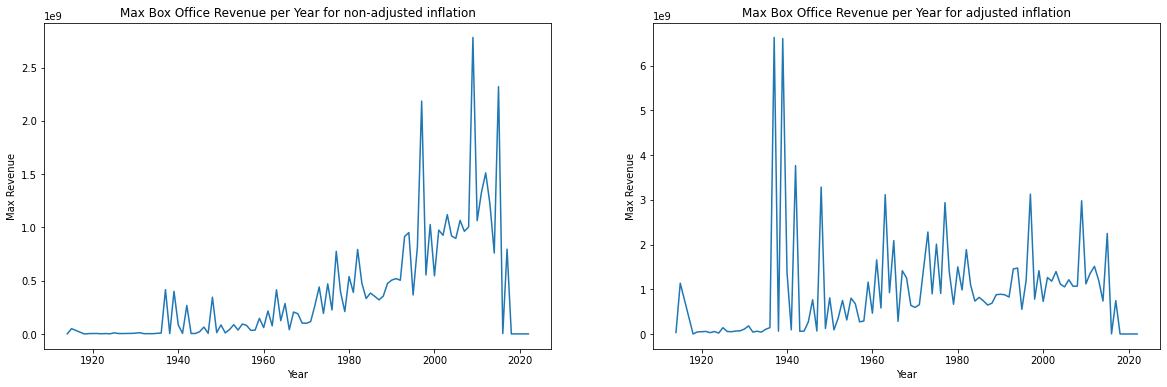

In [198]:
# Calculate the max box office revenue for each year
max_revenue_per_year = movies.groupby('year')['revenue'].max().reset_index()
max_revenue_per_year_adjusted = movies.groupby('year')['adjusted_revenue'].max().reset_index()

#x_values = us_yearly_inflation['year'].values
#y_values = us_yearly_inflation['avg_avg'].values

#plt.plot(x_values, y_values)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
# Create a line plot
axes[0].plot(max_revenue_per_year['year'], max_revenue_per_year['revenue'])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Max Revenue')
axes[0].set_title('Max Box Office Revenue per Year for non-adjusted inflation')
plt.grid(False)

# Create a line plot
axes[1].plot(max_revenue_per_year_adjusted['year'], max_revenue_per_year_adjusted['adjusted_revenue'])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Max Revenue')
axes[1].set_title('Max Box Office Revenue per Year for adjusted inflation')
plt.grid(False)
plt.grid(False)

plt.show()

We can plot the max box office revenue for every year. Note that we are interested in the best movies so we don't plot average or median.

In [199]:
# movie with most revenue
highest_revenue_movie = movies[movies["revenue"] == movies["revenue"].max()]["name"].values[0]

# movie with most revenue
highest_adjusted_revenue_movie = movies[movies["adjusted_revenue"] == movies["adjusted_revenue"].max()]["name"].values[
    0]

print(f"Highest revenue movie: {highest_revenue_movie}")
print(f"Highest adjusted revenue movie: {highest_adjusted_revenue_movie}")

Highest revenue movie: Avatar
Highest adjusted revenue movie: Snow White and the Seven Dwarfs


Looking at the previous graph it seems like Avatar is the best movie! Until we adjust the revenue for inflation and see that it is actually Snow White and the Seven Dwarfs that is the movie that generated the most value.

In [200]:
movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,...,4.9,57000.0,3850.0,John Carpenter,2001.0,1.295952,1.815737e+07,3.628666e+07,1.128728e+07,4.930388e+06
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,...,6.8,2300.0,NaN,Henry King,1938.0,16.274561,5.858842e+07,3.254912e+07,NaN,NaN
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,...,7.5,31000.0,NaN,Kenneth Branagh,1989.0,1.852181,1.882019e+07,1.666963e+07,1.882019e+07,1.202676e+05


## Looking for a correlation between the rating and the revenue

In [201]:
pearson_corr = stats.pearsonr(movies['rating_score'], movies['adjusted_revenue'])

print('Pearson correlation coefficient: ', pearson_corr)
print('As we can see there is a weak correlation between the rating and the revenue')

Pearson correlation coefficient:  PearsonRResult(statistic=0.137178021438133, pvalue=2.329908373947409e-75)
As we can see there is a weak correlation between the rating and the revenue


The null-hypothesis states that there is no correlation between movie revenue and ratings. Based on this Pearson Correlation test, the p-value is smaller than 0.05, so we reject the null-hypothesis. However, the correlation coefficient is equal to 0.14, which is quite small. So we conclude that there is not a significant correlation between movie revenue and ratings.

### Therefore, we can define a success movie score, which combines both the revenue and ratings.

We define the score as a function composed of two components:

- $BORC$    : Box Office Revenue Component
- $RC$      : Rating Component

These components can be computed with the Adjusted Movie Revenue (which we write define as $AMR$) and the movie rating (we will write as $MR$)

We log-transform the data and define $x = \log(AMR)$ and $y = MR$

$
\begin{cases}
    BORC = \frac{x - \min(x)}{\max(x) - \min(x)}\\
    RC = \frac{y - \min(y)}{\max(y) - \min(y)}
\end{cases}
$

As such, we have $BORC, RC \in [0, 1]$

We define a weight $\alpha \in [0, 1]$ and take the convex combinations of $BORC$ and $RC$. This weight controls the importance we give to each of our two components in our metric. Its importance will be determined in the future and we will adjust it accordingly to the study. Multiplying by 100 gives us a final score 

$$Movie Score = 100\left(\alpha BORC + (1 - \alpha) RC \right)$$

In [202]:
# Calculate the components
log_adj_revenue = np.log(movies['adjusted_revenue'].values)
movie_rating = movies['rating_score'].values

movies.loc[:, 'BORC'] = (log_adj_revenue - np.min(log_adj_revenue)) / (
            np.max(log_adj_revenue) - np.min(log_adj_revenue))
movies.loc[:, 'RC'] = (movie_rating - np.min(movie_rating)) / (np.max(movie_rating) - np.min(movie_rating))

# Calculate Movie Score
alpha = 1 / 2
movies.loc[:, 'movie_score'] = 100 * (alpha * movies['BORC'] + (1 - alpha) * movies['RC'])

movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,producer,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,...,John Carpenter,2001.0,1.295952,1.815737e+07,3.628666e+07,1.128728e+07,4.930388e+06,0.726723,0.463415,59.506901
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,...,Henry King,1938.0,16.274561,5.858842e+07,3.254912e+07,NaN,NaN,0.780983,0.695122,73.805262
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,...,Kenneth Branagh,1989.0,1.852181,1.882019e+07,1.666963e+07,1.882019e+07,1.202676e+05,0.728384,0.780488,75.443593


### Now that we have the movie scores we can keep the top T percent and consider these as the Good films that we want to study

In [203]:
T = 75
num_movies = movies.shape[0]
movies = movies.sort_values("movie_score", ascending=False)

# Set the 'Good Movie' column for the first N% rows to 1 and the rest to 0 using iloc
movies['Good Movie'] = movies['movie_score'].apply(lambda x: 1 if x >= T else 0)

df_good_movies = movies[movies["movie_score"] >= T].copy()
df_bad_movies = movies[movies["movie_score"] < T].copy()

In [204]:
df_good_movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G...",6000000.0,...,1972.0,5.488629,1.473697e+09,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",94000000.0,...,2003.0,1.246866,1.396402e+09,1.172054e+08,4.730948e+08,9.055949e+07,0.927864,0.963415,94.563911,1
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",185000000.0,...,2008.0,1.066249,1.071109e+09,1.972560e+08,5.704292e+08,1.689060e+08,0.915580,0.963415,93.949723,1


In [205]:
df_bad_movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie
2118,28272795,/m/0g4pmz_,One Day,2011-08-08,56706628.0,107.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",15000000.0,...,2011.0,1.021000,5.789747e+07,15315000.0,1.413449e+07,5.186237e+06,0.780434,0.719512,74.997299,0
1590,5301628,/m/0ddf9m,Eye of the Needle,1981-07-24,17583634.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",NaN,...,1981.0,2.526257,4.442078e+07,NaN,4.442078e+07,NaN,0.768161,0.731707,74.993418,0
10259,1528272,/m/0586x1,Murder in the First,1995-01-20,17381942.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,...,1995.0,1.507163,2.619741e+07,NaN,2.619741e+07,7.112583e+06,0.743703,0.756098,74.990022,0


We now have 2 datasets: of good movies and of bad ones

# Features
## We will find the effect of each feature on the movie’s success score. 

In [206]:
processed_directory = ADDITIONAL_FOLDER
try:
    os.makedirs(processed_directory)
except:
    pass

In [37]:
merged = movies.copy(deep=True)

In [38]:
merged["countries"].iloc[5]

'{"/m/09c7w0": "United States of America"}'

In [39]:
for key in ast.literal_eval(merged["countries"][5]).keys():
    print(key)

/m/09c7w0


In [40]:
# country dataframe & dictionary
try:
    movie_countries = pd.read_csv(processed_directory + "/movie_countries.csv")
    country_dictionary = pkl.load(open(processed_directory + "/country_dictionary.pickle", "rb"))

except:
    movie_countries = pd.DataFrame(columns=["wikipedia_movie_id", "country_id"])
    country_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wikiID = merged["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["countries"][i])
        data = [{'wikipedia_movie_id': wikiID, 'country_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_countries = pd.concat([movie_countries, dataframe], axis=0)
        country_dictionary.update(dico)

    # save the dataframe to csv
    movie_countries.to_csv(processed_directory + "/movie_countries.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/country_dictionary.pickle', 'wb') as handle:
        pkl.dump(country_dictionary, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [41]:
# language dataframe & dictionary
try:
    movie_languages = pd.read_csv(processed_directory + "/movie_languages.csv")
    language_dictionary = pkl.load(open(processed_directory + "/language_dictionary.pickle", "rb"))
except:
    movie_languages = pd.DataFrame(columns=["wikipedia_movie_id", "language_id"])
    language_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wikiID = merged["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["languages"][i])
        data = [{'wikipedia_movie_id': wikiID, 'language_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_languages = pd.concat([movie_languages, dataframe], axis=0)
        language_dictionary.update(dico)

    # save the dataframe to csv
    movie_languages.to_csv(processed_directory + "/movie_languages.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/language_dictionary.pickle', 'wb') as handle:
        pkl.dump(language_dictionary, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [42]:
try:
    movie_genres = pd.read_csv(processed_directory + "/movie_genres.csv")
    genre_dictionary = pkl.load(open(processed_directory + "/genre_dictionary.pickle", "rb"))
except:
    movie_genres = pd.DataFrame(columns=["wikipedia_movie_id", "genre_id"])
    genre_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wiki_id = movies["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["genres"][i])
        data = [{'wikipedia_movie_id': wiki_id, 'genre_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_genres = pd.concat([movie_genres, dataframe], axis=0)
        genre_dictionary.update(dico)

    # save the dataframe to csv
    movie_genres.to_csv(processed_directory + "/movie_genres.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/genre_dictionary.pickle', 'wb') as handle:
        pkl.dump(genre_dictionary, handle, protocol=pkl.HIGHEST_PROTOCOL)

We can now start by properly merging in the two new dataframes we created:

In [43]:
merged_languages = pd.merge(merged, movie_languages, on="wikipedia_movie_id", how="inner")
merged_countries = pd.merge(merged_languages, movie_countries, on="wikipedia_movie_id", how="inner")
merged_all = pd.merge(merged_countries, movie_genres, on="wikipedia_movie_id", how="inner")
merged_all.drop(columns=["languages", "countries", "genres"], inplace=True)
merged_all.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,budget,gross_domestic,opening_weekend,rating_score,...,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie,language_id,country_id,genre_id
0,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,/m/04h9h,/m/09c7w0,/m/0lsxr
1,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,/m/04h9h,/m/09c7w0,/m/0gw5w78
2,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,/m/04h9h,/m/09c7w0,/m/0hj3n01


We can also replace the language and country ids by their corresponding values

In [44]:
merged_all["language_id"].replace(language_dictionary, inplace=True)
merged_all["country_id"].replace(country_dictionary, inplace=True)
merged_all["genre_id"].replace(genre_dictionary, inplace=True)

#rename language_id as language, country_id as country and genre_id as genre
merged_all.rename(columns={"language_id": "language", "country_id": "country", "genre_id": "genre"}, inplace=True)
merged_all.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,budget,gross_domestic,opening_weekend,rating_score,...,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie,language,country,genre
0,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,Latin Language,United States of America,Crime Fiction
1,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,Latin Language,United States of America,Gangster Film
2,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,Latin Language,United States of America,Crime Drama


<Axes: title={'center': 'Total score per country'}, xlabel='Country', ylabel='Total score'>

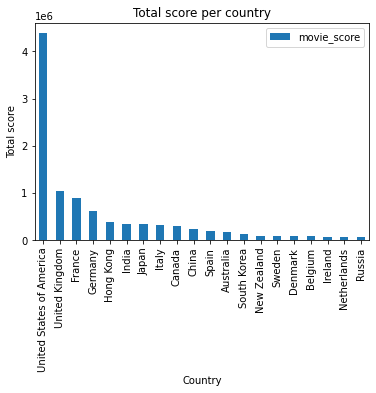

In [45]:
inflation_group = merged_all.groupby(["country"]).agg({"movie_score": "sum"})
inflation_group.sort_values(by="movie_score", ascending=False).head(20).plot(kind="bar",
                                                                             title="Total score per country",
                                                                             xlabel="Country", ylabel="Total score")

In [46]:
# Top 20 countries that have generated movies with the highest scores
top_20_countries = inflation_group.sort_values(by="movie_score", ascending=False).head(20).index.values

<Axes: title={'center': 'Total score per language'}, xlabel='Language', ylabel='Total score'>

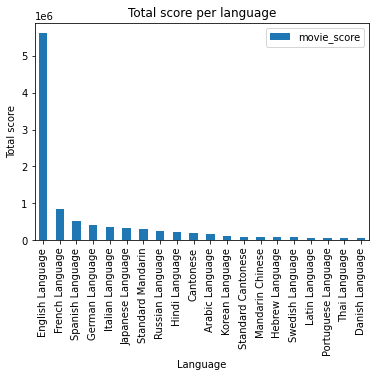

In [47]:
# plotting the average movie score per language
inflation_language_group = merged_all.groupby(["language"]).agg({"movie_score": "sum"})
inflation_language_group.sort_values(by="movie_score", ascending=False).head(20).plot(kind="bar",
                                                                                      title="Total score per language",
                                                                                      xlabel="Language",
                                                                                      ylabel="Total score")

Following the evolution over the years of the 20 countries that have generated the best movie score

In [48]:
top_20_merged = merged_all[merged_all["country"].isin(top_20_countries)]
top_20_merged.dropna(subset=["movie_score"], inplace=True)
top_20_grouped = top_20_merged.groupby(["year", "country"])
top_20_sum = top_20_grouped.agg({"movie_score": "sum"})

/var/folders/sl/l4r0mck97851fkfhdlbf8shh0000gq/T/ipykernel_8848/629807857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_merged.dropna(subset=["movie_score"], inplace=True)


In [49]:
# for each country compute the mean over each year
data_country_merged = top_20_grouped.agg(mean=("movie_score", "mean"), 
                                         std=("movie_score", "std"), 
                                         count=("movie_score", "count")).reset_index()
countries = top_20_merged["country"].unique()

data_country_merged.head(3)

,year,country,mean,std,count
0,1914.0,United States of America,57.256782,9.932869,25
1,1915.0,United States of America,77.012932,0.000000,14
2,1918.0,United States of America,60.470042,0.000000,5


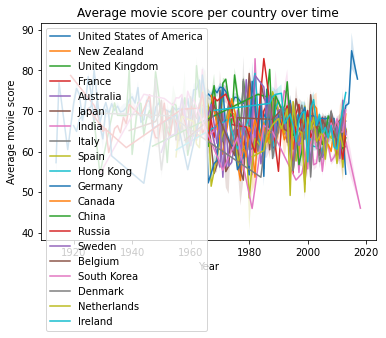

In [50]:
for country in countries:
    data_country = data_country_merged[data_country_merged["country"] == country]

    country_IC_plus = data_country["mean"] + 1.96*data_country["std"]/np.sqrt(data_country["count"])
    country_IC_minus = data_country["mean"] - 1.96*data_country["std"]/np.sqrt(data_country["count"])
    
    plt.plot(data_country["year"], data_country["mean"], label=country)
    plt.fill_between(data_country["year"], country_IC_minus, country_IC_plus, alpha=0.2)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Average movie score")
plt.title("Average movie score per country over time")
plt.show()

In [51]:
from dash import dcc, html
import plotly.express as px
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': 'All', 'value': 'All'}] + [{'label': genre, 'value': genre} for genre in genres_cols],
        value='All',
        multi=True  # Allow multiple selections
    ),
    dcc.Graph(id='genre-plot')
])
@app.callback(
    Output('genre-plot', 'figure'),
    [Input('genre-dropdown', 'value')]
)
def update_graph(selected_genres):
    if 'All' in selected_genres or not selected_genres:
        filtered_df = genres_and_sentiments[needed_columns]
        display(filtered_df)
    else:
        filtered_df = genres_and_sentiments[genres_and_sentiments[selected_genres].any(axis=1)][needed_columns]
    # Create the plot
    fig = px.density_contour(filtered_df, x='sentiment_intensity', y='movie_score', 
                             title='Density Contour of Movie Score vs Sentiment Intensity')
    fig.update_traces(contours_coloring='fill', contours_showlabels=True)
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


NameError: name 'genres_cols' is not defined

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming 'countries' is a list of unique countries in your dataset

# Create an empty figure
fig = go.Figure()

for i, country in enumerate(countries):
    data_country = data_country_merged[data_country_merged["country"] == country]

    country_IC_plus = data_country["mean"] + 1.96 * data_country["std"] / np.sqrt(data_country["count"])
    country_IC_minus = data_country["mean"] - 1.96 * data_country["std"] / np.sqrt(data_country["count"])

    # Add trace for the mean line
    fig.add_trace(go.Scatter(
        x=data_country["year"],
        y=data_country["mean"],
        name=country,
        mode='lines',
        line=dict(color='blue'),  # You can customize the line color
        hoverinfo='text',
        text=[f'Mean: {mean}<br>Year: {year}' for mean, year in zip(data_country["mean"], data_country["year"])]
    ))

    # Add trace for the upper bound of the confidence interval
    fig.add_trace(go.Scatter(
        x=data_country["year"].tolist() + data_country["year"].tolist()[::-1],
        y=country_IC_plus.tolist() + country_IC_minus.tolist()[::-1],
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',  # Fill color
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        name=f'{country}_CI',  # Add a unique name for the confidence interval trace
    ))

# Create dropdown buttons
buttons = []
for country in countries:
    buttons.append(
        dict(label=country,
             method='update',
             args=[{'visible': [country == trace.name or f'{country}_CI' == trace.name for trace in fig.data]},
                   {'title': f'Average movie score for {country} over time'}])
    )

# Update layout to include dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            type='dropdown',
            showactive=True,
            x=0.1,
            y=1.15,
            buttons=buttons,
        )
    ]
)

# Set layout parameters
fig.update_layout(
    title="Average movie score per country over time",
    xaxis_title="Year",
    yaxis_title="Average movie score",
)

# Show the figure
fig.show()


In [ ]:
top_20_mean[top_20_mean["country"] == "United States"]

In [ ]:
ax = top_20_sum.unstack().plot(kind='bar', stacked=True, title="Total score", xlabel="year", ylabel="Total score",
                               figsize=(20, 10))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We clearly see that globally, the movie industry has been making more successful movies over the years. Though we see a drop during the years that follow 2008 which might be a consequence of the subprime's crisis.

In [ ]:
top_20_grouped[top_20_grouped["country"]=="France"]

In [ ]:
top_20_avg = top_20_grouped.agg({"movie_score": "mean"})
top_20_std = top_20_grouped.agg({"movie_score": "std"})

## Movie score analysis over the length of a movie

Aboout 35 movies have a runtime that is longer that 500 minutes, which does not make sense.

In [ ]:
merged_all[merged_all["runtime"] >= 500]["runtime"].describe()

We can remove these outliers and perform a `pearson correlation` test between the `movie_runtime` and its `movie_score`

In [ ]:
merged_with_inflation_no_outlier = merged_all[merged_all["runtime"] < 500]
non_nan_merged_with_inflation = merged_with_inflation_no_outlier[
    ~merged_with_inflation_no_outlier["movie_score"].isna()]
non_nan_merged_with_inflation = non_nan_merged_with_inflation[~non_nan_merged_with_inflation["runtime"].isna()]
stats.pearsonr(non_nan_merged_with_inflation["runtime"], non_nan_merged_with_inflation["movie_score"])

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.21` which indicates a weak positive correlation between `runtime` of a movie and its `movie_score`

In [ ]:
# plotting revenue vs runtime with a linear regression
sns.lmplot(x="runtime", y="movie_score", data=non_nan_merged_with_inflation, scatter_kws={'alpha':0.01})
#plt.yscale('log')
plt.xlabel("movie_score in minutes")
plt.ylabel("Total score")
plt.title("Total score vs Runtime")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.hexbin(x=non_nan_merged_with_inflation["runtime"], y=non_nan_merged_with_inflation["movie_score"], gridsize=100, cmap="Blues", mincnt=1)

sns.regplot(x="runtime", y="movie_score", data=non_nan_merged_with_inflation, scatter=False, ax=ax, color="red")
plt.xlabel("Runtime in minutes")
plt.ylabel("Total score")
plt.title("Score vs Runtime")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.hexbin(x=non_nan_merged_with_inflation["runtime"], y=non_nan_merged_with_inflation["movie_score"], gridsize=100, cmap="Blues", mincnt=1)

sns.regplot(x="runtime", y="movie_score", data=non_nan_merged_with_inflation, scatter=False, ax=ax, color="blue")
plt.xlabel("Runtime in minutes")
plt.ylabel("Total score")
plt.title("Score vs Runtime")

In [ ]:
non_nan_merged_with_inflation["runtime"].describe()

## Producers

Plotting the 20 producers that have generated the most successful movies over their career 

In [ ]:
scraped_grouped = merged_all.groupby(["producer"]).agg({"movie_score": "sum"})
scraped_grouped.sort_values(by="movie_score", ascending=False).head(20).plot(kind="bar",
                                                                             title="Total score per producer",
                                                                             xlabel="Producer", ylabel="Total score")

## Movie budget

We can remove the movies that have a `budget` larger than $1B and perform a `pearson correlation` test between the `budget` and its `movie_score`

In [ ]:
non_nan_budget = movies.copy(deep=True)
non_nan_budget = non_nan_budget[~non_nan_budget["adjusted_budget"].isna()]

non_nan_budget = non_nan_budget[non_nan_budget["adjusted_budget"] < 1e9]

stats.pearsonr(non_nan_budget["adjusted_budget"], non_nan_budget["movie_score"])

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.2` which indicates a weak positive correlation between `budget` of a movie and its `movie_score`

In [ ]:
# plotting movie_score vs runtime with a linear regression
sns.lmplot(x="adjusted_budget", y="adjusted_revenue", data=non_nan_budget, scatter_kws={'alpha':0.01})
plt.xlabel("Budget")
plt.ylabel("adjusted_revenue")
plt.title("Score vs Budget")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.hexbin(x=non_nan_merged_with_inflation["adjusted_budget"], y=non_nan_merged_with_inflation["movie_score"], gridsize=100, cmap="Blues", mincnt=1)

sns.regplot(x="adjusted_budget", y="movie_score", data=non_nan_merged_with_inflation, scatter=False, ax=ax, color="red")
plt.xlabel("adjusted budget")
plt.ylabel("Total score")
plt.title("Score vs Adjusted budget")

In [ ]:
non_nan_budget["adjusted_budget"].describe()

In [ ]:
import plotly.express as px

In [ ]:
new_df = non_nan_budget[["runtime", "movie_score"]].copy(deep=True).dropna()
#new_df["runtime"] = np.log(new_df["runtime"])
#new_df["movie_score"] = np.log(new_df["movie_score"])

fig = px.density_contour(new_df, x="runtime", y="movie_score")

fig.update_layout(
    title="Movie Score vs Runtime",
    xaxis_title="Runtime",
    yaxis_title="Movie Score",
)

fig.update_xaxes(range=[70, 150])
fig.update_yaxes(range=[30, 100])
fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.show()

In [ ]:
new_df = non_nan_budget[["adjusted_budget", "movie_score"]].copy(deep=True)
#new_df["adjusted_budget"] = np.log(new_df["adjusted_budget"])
#new_df["movie_score"] = np.log(new_df["movie_score"])

fig = px.density_contour(new_df, x="adjusted_budget", y="movie_score")

fig.update_yaxes(range=[30, 90])
fig.update_xaxes(range=[-20000000, 120000000])
fig.update_traces(contours_coloring="fill", contours_showlabels = True)

fig.update_layout(
    title="Movie Score vs Budget",
    xaxis_title="Budget (Adjusted for inflation)",
    yaxis_title="Movie Score",
)

fig.show()

## Genres

In [207]:
movies_genres = movies.copy(deep=True)
movies_genres.head()

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G...",6000000.0,...,1972.0,5.488629,1.473697e+09,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",94000000.0,...,2003.0,1.246866,1.396402e+09,1.172054e+08,4.730948e+08,9.055949e+07,0.927864,0.963415,94.563911,1
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",185000000.0,...,2008.0,1.066249,1.071109e+09,1.972560e+08,5.704292e+08,1.689060e+08,0.915580,0.963415,93.949723,1
4837,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},{},11000000.0,...,1977.0,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1
17567,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",11000000.0,...,1977.0,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1


In [208]:
def extract_json_values(df, column):
    """
    This function takes a dataframe and a column name containing JSON strings.
    It parses the JSON and preserves the content/values as a list of lists.
    """
    # Extract the values from each JSON object and append to a list
    values_list = []
    for json_str in df[column]:
        try:
            # Parse the JSON data
            json_data = json.loads(json_str)
            # Extract values and append to the list
            values_list.append(list(json_data.values()))
        except json.JSONDecodeError:
            # If JSON is not valid, append a None or handle it as needed
            values_list.append(None)

    return values_list

In [209]:
movies_genres['genres'] = extract_json_values(movies_genres, "genres")
movies_genres.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,year,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,1972.0,5.488629,1.473697e+09,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,2003.0,1.246866,1.396402e+09,1.172054e+08,4.730948e+08,9.055949e+07,0.927864,0.963415,94.563911,1
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,2008.0,1.066249,1.071109e+09,1.972560e+08,5.704292e+08,1.689060e+08,0.915580,0.963415,93.949723,1
4837,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,1977.0,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1
17567,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,1977.0,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1
2411,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",13000000.0,...,1974.0,4.656037,8.986151e+08,6.052848e+07,2.227196e+08,7.981239e+05,0.907447,0.963415,93.543061,1
8404,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Film adaptation, Costume drama, Roadshow thea...",3977000.0,...,1939.0,16.505640,6.602256e+09,6.564293e+07,3.315689e+09,1.968451e+07,0.999819,0.865854,93.283655,1
1931,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,2002.0,1.275543,1.181213e+09,1.199011e+08,4.374508e+08,7.909330e+07,0.920112,0.939024,92.956817,1
12233,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980-05-21,5.383751e+08,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Space opera, Fant...",18000000.0,...,1980.0,2.786462,1.500162e+09,5.015631e+07,8.157477e+08,1.368287e+07,0.931183,0.926829,92.900633,1
17401,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",93000000.0,...,2001.0,1.295952,1.129462e+09,1.205236e+08,4.096705e+08,6.118383e+07,0.918037,0.939024,92.853061,1


Let’s see how many movies there are per gender.

In [210]:
# Assuming your DataFrame is named 'movies'
# Replace 'YourColumnName' with the actual column name in your DataFrame
genres = movies_genres['genres']

# Create an empty dictionary to store genre counts
genres_counts = {}

# Iterate through each list of genres in the 'genres' column
for genres_list in genres:
    # Update the counts in the dictionary
    for genre in genres_list:
        genres_counts[genre] = genres_counts.get(genre, 0) + 1

# Convert the dictionary to a DataFrame for better visualization
genres_counts_df = pd.DataFrame(list(genres_counts.items()), columns=['Genre', 'Count'])

# Sort the DataFrame by the count in descending order
genres_counts_df = genres_counts_df.sort_values(by='Count', ascending=False)

# Display the result
genres_counts_df.head(362)

,Genre,Count
5,Drama,9587
44,Comedy,5579
26,Romance Film,3856
14,Thriller,3518
79,World cinema,3227
...,...,...
277,Clay animation,1
275,Filmed Play,1
274,Goat gland,1
262,Supermarionation,1


As we can see above, there are many genres who are very similar (technically the same but differ in terms of expression): (Comedy = Comedy film = Comedy, …), and some of them are outliers (very few movies per genre). Moreover, the 16 most popular genres are: 
`Action`, `Adventure`, `Animation`, `Comedy`, `Crime`, `Drama`, `Family`, `Fantasy`, `Period Piece`, `Horror`, `Musical`, `Romance`, `Science Fiction`, `Sport`, `Thriller and War film`. 
Therefore, we regroup all the movies into the 16 genres above (the movies who have the same genre or a very similar one). 

In [211]:
# Assuming your DataFrame with genre counts is named 'genre_counts_df'
# Replace 'YourColumnName' with the actual column name in your DataFrame
genres_column = genres_counts_df['Genre']

# Define the genres of interest
primary_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
                  'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
                  'Sport', 'Thriller', 'War film']

# Create a dictionary to store the grouped genres and counts
grouped_genre_data = {'Primary Genre': [], 'Grouped Genres': [], 'Count': [], 'Proportion (%)': []}

# Group genres based on keywords
for primary_genre in primary_genres:
    # Find genres that contain the keyword
    grouped_genres = [genre for genre in genres_column if primary_genre.lower() in genre.lower()]

    # Sum the counts for the grouped genres
    grouped_count = genres_counts_df[genres_counts_df['Genre'].isin(grouped_genres)]['Count'].sum()

    # Add data to the dictionary
    grouped_genre_data['Primary Genre'].append(primary_genre)
    grouped_genre_data['Grouped Genres'].append(', '.join(grouped_genres))
    grouped_genre_data['Count'].append(grouped_count)

# Compute the total number of movies 
total_nb_movies = sum(grouped_genre_data['Count'])

grouped_genre_data['Proportion (%)'] = np.round((grouped_genre_data['Count']/total_nb_movies)*100, 2)

# Create a new DataFrame from the grouped data dictionary
grouped_genre_counts_df = pd.DataFrame(grouped_genre_data)

# Reorder the DataFrame
grouped_genre_counts_df = grouped_genre_counts_df.sort_values(by='Count', ascending=False)

# Display the result
grouped_genre_counts_df.head(18)

,Primary Genre,Grouped Genres,Count,Proportion (%)
5,Drama,"Drama, Romantic drama, Comedy-drama, Family Dr...",14646,24.69
3,Comedy,"Comedy, Romantic comedy, Comedy-drama, Black c...",10897,18.37
14,Thriller,"Thriller, Crime Thriller, Psychological thrill...",5763,9.71
0,Action,"Action, Action/Adventure, Action Thrillers, Ac...",5327,8.98
1,Adventure,"Action/Adventure, Adventure, Family-Oriented A...",4137,6.97
11,Romance,Romance Film,3856,6.50
4,Crime,"Crime Fiction, Crime Thriller, Crime Drama, Cr...",3703,6.24
6,Family,"Family Film, Family Drama, Children's/Family, ...",2274,3.83
9,Horror,"Horror, Horror Comedy, Natural horror films, S...",1658,2.79
7,Fantasy,"Fantasy, Children's Fantasy, Fantasy Comedy, F...",1544,2.60


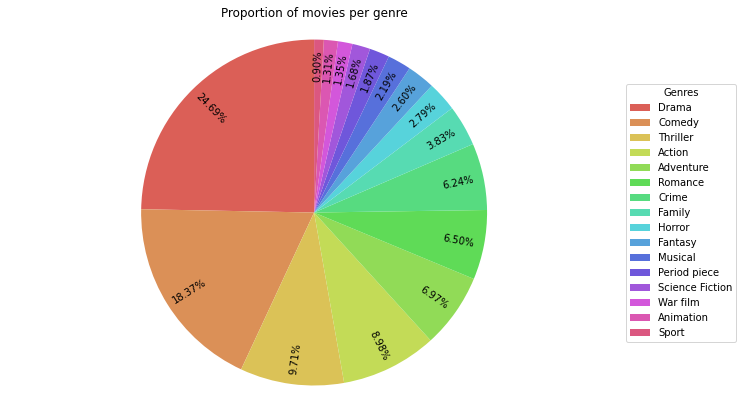

In [273]:
fig, ax = plt.subplots(figsize=(11, 7))

wedge_colors = sns.color_palette("hls", 16)

wedges, genres, prop_texts = ax.pie(grouped_genre_counts_df['Proportion (%)'], labels=None, startangle=90,
                                     autopct='%2.2f%%', rotatelabels=True, pctdistance=0.85, colors=wedge_colors)
for genre, prop_text in zip(genres, prop_texts):
    prop_text.set_rotation(genre.get_rotation())
plt.title('Proportion of movies per genre')
plt.axis('equal')
plt.legend(grouped_genre_counts_df['Primary Genre'], title="Genres", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We will create a new column called `Generic Genre`, which is the same as the genres column but keeping only the 16 most popular genres, and removing the rest. 

In [213]:
movies_genres['Generic Genre'] = np.nan
movies_genres.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie,Generic Genre
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,5.488629,1.473697e+09,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,NaN
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,1.246866,1.396402e+09,1.172054e+08,4.730948e+08,9.055949e+07,0.927864,0.963415,94.563911,1,NaN
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,1.066249,1.071109e+09,1.972560e+08,5.704292e+08,1.689060e+08,0.915580,0.963415,93.949723,1,NaN
4837,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1,NaN
17567,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1,NaN
2411,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",13000000.0,...,4.656037,8.986151e+08,6.052848e+07,2.227196e+08,7.981239e+05,0.907447,0.963415,93.543061,1,NaN
8404,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Film adaptation, Costume drama, Roadshow thea...",3977000.0,...,16.505640,6.602256e+09,6.564293e+07,3.315689e+09,1.968451e+07,0.999819,0.865854,93.283655,1,NaN
1931,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,1.275543,1.181213e+09,1.199011e+08,4.374508e+08,7.909330e+07,0.920112,0.939024,92.956817,1,NaN
12233,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980-05-21,5.383751e+08,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Space opera, Fant...",18000000.0,...,2.786462,1.500162e+09,5.015631e+07,8.157477e+08,1.368287e+07,0.931183,0.926829,92.900633,1,NaN
17401,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",93000000.0,...,1.295952,1.129462e+09,1.205236e+08,4.096705e+08,6.118383e+07,0.918037,0.939024,92.853061,1,NaN


In [214]:
# Assuming 'movies' is your DataFrame
# If not, you need to define or read it before this point

# List of genres to create tables for
genres_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
               'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
               'Sport', 'Thriller', 'War film']


# Define a function to get the list of genres for a movie
def get_genre_list(movie_genres):
    return [genre for genre in genres_list if any(genre.lower() in element.lower().strip() for element in movie_genres)]


# Apply the function to create the 'Generic Genre' column
movies_genres['Generic Genre'] = movies_genres['genres'].apply(get_genre_list)

movies_genres.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie,Generic Genre
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,5.488629,1.473697e+09,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,"[Crime, Drama, Family, Period piece]"
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,1.246866,1.396402e+09,1.172054e+08,4.730948e+08,9.055949e+07,0.927864,0.963415,94.563911,1,"[Action, Adventure, Drama, Fantasy]"
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,1.066249,1.071109e+09,1.972560e+08,5.704292e+08,1.689060e+08,0.915580,0.963415,93.949723,1,"[Action, Adventure, Crime, Drama, Thriller]"
4837,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1,[]
17567,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1,"[Action, Adventure, Family, Fantasy, Science F..."
2411,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",13000000.0,...,4.656037,8.986151e+08,6.052848e+07,2.227196e+08,7.981239e+05,0.907447,0.963415,93.543061,1,"[Crime, Drama]"
8404,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Film adaptation, Costume drama, Roadshow thea...",3977000.0,...,16.505640,6.602256e+09,6.564293e+07,3.315689e+09,1.968451e+07,0.999819,0.865854,93.283655,1,"[Drama, Period piece, Romance, War film]"
1931,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,1.275543,1.181213e+09,1.199011e+08,4.374508e+08,7.909330e+07,0.920112,0.939024,92.956817,1,"[Action, Adventure, Drama, Fantasy]"
12233,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980-05-21,5.383751e+08,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Space opera, Fant...",18000000.0,...,2.786462,1.500162e+09,5.015631e+07,8.157477e+08,1.368287e+07,0.931183,0.926829,92.900633,1,"[Action, Adventure, Family, Fantasy, Science F..."
17401,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",93000000.0,...,1.295952,1.129462e+09,1.205236e+08,4.096705e+08,6.118383e+07,0.918037,0.939024,92.853061,1,"[Action, Adventure, Drama, Fantasy]"


We will now create a dictionary consisting of 16 different dataframes (1 for each genre). Each one of these dataframes corresponds to all the movie of the specific genre. 

In [215]:
genres_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
               'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
               'Sport', 'Thriller', 'War film']
#for genre in genres_list: 
#    genre_movies = movies[movies['Generic Genre'].apply(lambda x: genre in x if x is not None else False)]
#   genre_movies.head(10)

genre_dataframes = {}

for genre in genres_list:
    genre_movies = movies_genres[movies_genres['Generic Genre'].apply(lambda x: genre in x if x is not None else False)]
    genre_dataframes[genre] = genre_movies

# Access specific genre DataFrames using genre names
action_movies = genre_dataframes['Action']
adventure_movies = genre_dataframes['Adventure']
animation_movies = genre_dataframes['Animation']
comedy_movies = genre_dataframes['Comedy']
crime_movies = genre_dataframes['Crime']
drama_movies = genre_dataframes['Drama']
family_movies = genre_dataframes['Family']
fantasy_movies = genre_dataframes['Fantasy']
period_piece_movies = genre_dataframes['Period piece']
horror_movies = genre_dataframes['Horror']
musical_movies = genre_dataframes['Musical']
romance_movies = genre_dataframes['Romance']
scifi_movies = genre_dataframes['Science Fiction']
sport_movies = genre_dataframes['Sport']
thriller_movies = genre_dataframes['Thriller']
war_movies = genre_dataframes['War film']

Let’s now do a distribution of the movie score per genre.

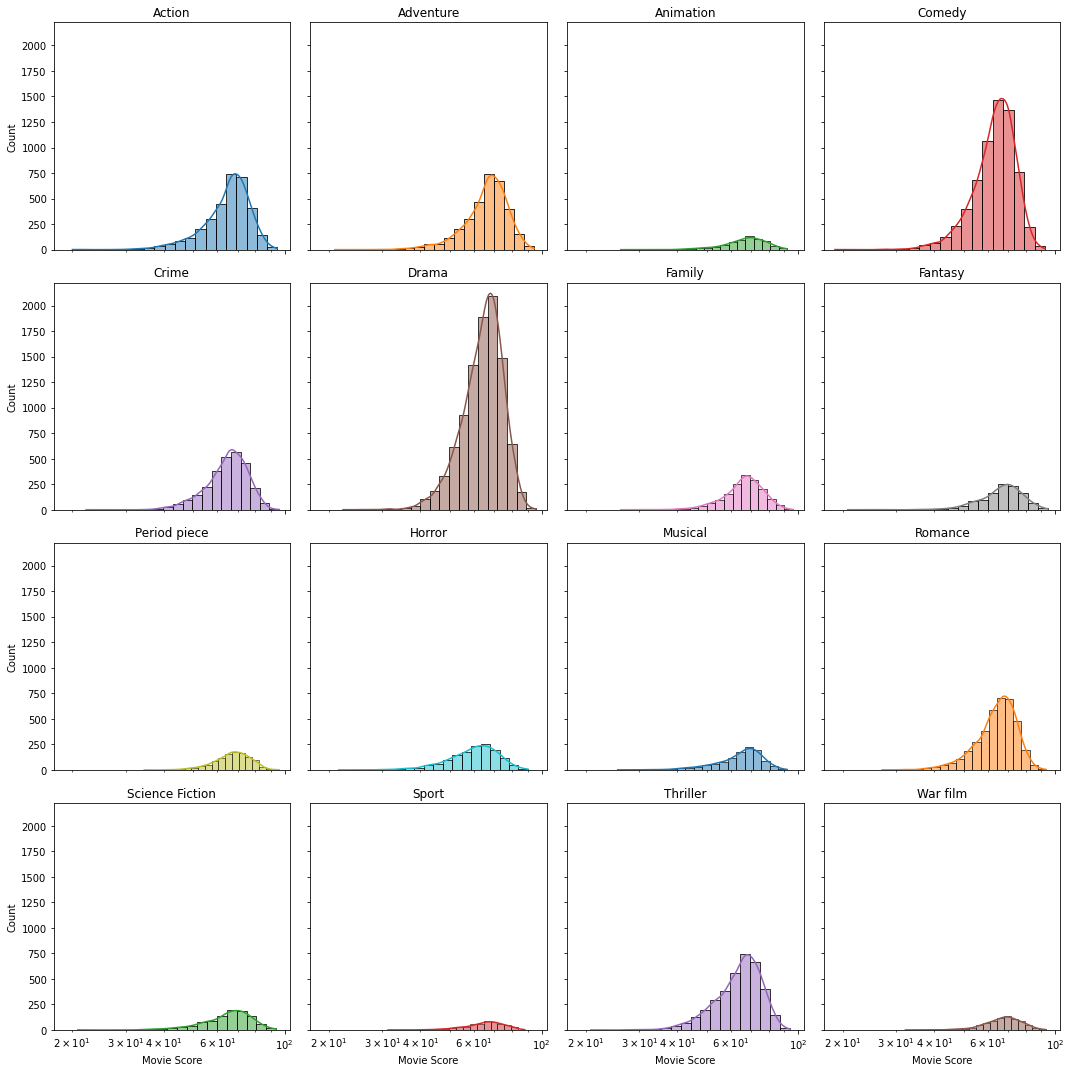

In [216]:
# Assuming 'genre_dataframes' is the dictionary of genre-specific DataFrames

# Create a 4x4 subplot grid for all genres except 'Action'
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the genres (excluding 'Action') and corresponding DataFrames
for i, (genre, genre_df) in enumerate(genre_dataframes.items()):
    if genre != 'Action':
        plt.xscale("log")
        # Plot the distribution of movie score for each genre
        sns.histplot(ax=axes[i], data=genre_df, x='movie_score', kde=True, bins=20, color='C{}'.format(i))
        axes[i].set_title(genre)
        axes[i].set_xlabel('Movie Score')
        axes[i].set_ylabel('Count')

# Plot 'Action' genre in the middle of the 5th row, 16th subplot
action_df = genre_dataframes['Action']
# Set x-axis to log scale for the 'Action' subplot
axes[0].set_xscale('log')
sns.histplot(ax=axes[0], data=action_df, x='movie_score', kde=True, bins=20)
axes[0].set_title('Action')
axes[0].set_xlabel('Movie Score')
axes[0].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [251]:
# Score statistics per genre
# Create empty dictionaries to store statistics for each genre
genre_stats = {'Mean': {}, 'Median': {}, 'Maximum': {}, 'Minimum': {}}

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    mean_score = genre_df['movie_score'].mean()
    median_score = genre_df['movie_score'].median()
    max_score = genre_df['movie_score'].max()
    min_score = genre_df['movie_score'].min()

    # Store the results in the dictionaries
    genre_stats['Mean'][genre] = mean_score
    genre_stats['Median'][genre] = median_score
    genre_stats['Maximum'][genre] = max_score
    genre_stats['Minimum'][genre] = min_score

# For easy displays, convert the dictionaries to Pandas DataFrames 
mean_df = pd.DataFrame(genre_stats['Mean'], index=['Mean Movie Score'])
median_df = pd.DataFrame(genre_stats['Median'], index=['Median Movie Score'])
max_df = pd.DataFrame(genre_stats['Maximum'], index=['Maximum Movie Score'])
min_df = pd.DataFrame(genre_stats['Minimum'], index=['Minimum Movie Score'])

# Concatenate the DataFrames along the columns to create a general DataFrame
general_stats_df = pd.concat([mean_df, median_df, max_df, min_df])

# Display the summary DataFrame
general_stats_df.head(10)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Period piece,Horror,Musical,Romance,Science Fiction,Sport,Thriller,War film
Mean Movie Score,65.451447,66.526025,67.463643,63.719516,65.224068,64.598715,66.472288,67.071766,67.824714,60.494450,64.905501,64.682798,65.605242,65.649396,64.376111,68.043597
Median Movie Score,66.730583,67.447774,68.139762,64.465856,66.026910,65.357683,67.062700,67.910670,68.102760,61.081979,66.517157,65.651986,66.794318,66.479787,65.536820,68.334888
Maximum Movie Score,94.563911,94.563911,91.640925,92.683054,95.908194,95.908194,95.908194,94.563911,95.908194,90.211079,91.640925,93.283655,93.846619,88.078265,93.949723,93.283655
Minimum Movie Score,20.068884,20.918441,26.091910,18.884183,22.265881,22.265881,26.091910,20.804988,34.584855,21.564511,25.494209,26.999474,20.918441,31.287348,20.804988,32.181485


In [252]:
# Identify which genre has the highest and lowest values for each statistic
# Mean 
highest_mean_genre = general_stats_df.loc['Mean Movie Score'].idxmax()
lowest_mean_genre = general_stats_df.loc['Mean Movie Score'].idxmin()

# Display the results
print(f"Highest Mean Movie Score Genre: {highest_mean_genre}")
print(f"Lowest Mean Movie Score Genre: {lowest_mean_genre}")

Highest Mean Movie Score Genre: War film
Lowest Mean Movie Score Genre: Horror


In [253]:
# Median
highest_median_genre = general_stats_df.loc['Median Movie Score'].idxmax()
lowest_median_genre = general_stats_df.loc['Median Movie Score'].idxmin()

print(f"Highest Median Movie Score Genre: {highest_median_genre}")
print(f"Lowest Median Movie Score Genre: {lowest_median_genre}")

Highest Median Movie Score Genre: War film
Lowest Median Movie Score Genre: Horror


In [254]:
# Max
highest_max_genre = general_stats_df.loc['Maximum Movie Score'].idxmax()
lowest_max_genre = general_stats_df.loc['Maximum Movie Score'].idxmin()

print(f"Highest Maximum Movie Score Genre: {highest_max_genre}")
print(f"Lowest Maximum Movie Score Genre: {lowest_max_genre}")

Highest Maximum Movie Score Genre: Crime
Lowest Maximum Movie Score Genre: Sport


In [255]:
# Min
highest_min_genre = general_stats_df.loc['Minimum Movie Score'].idxmax()
lowest_min_genre = general_stats_df.loc['Minimum Movie Score'].idxmin()

print(f"Highest Minimum Movie Score Genre: {highest_min_genre}")
print(f"Lowest Minimum Movie Score Genre: {lowest_min_genre}")

Highest Minimum Movie Score Genre: Period piece
Lowest Minimum Movie Score Genre: Comedy


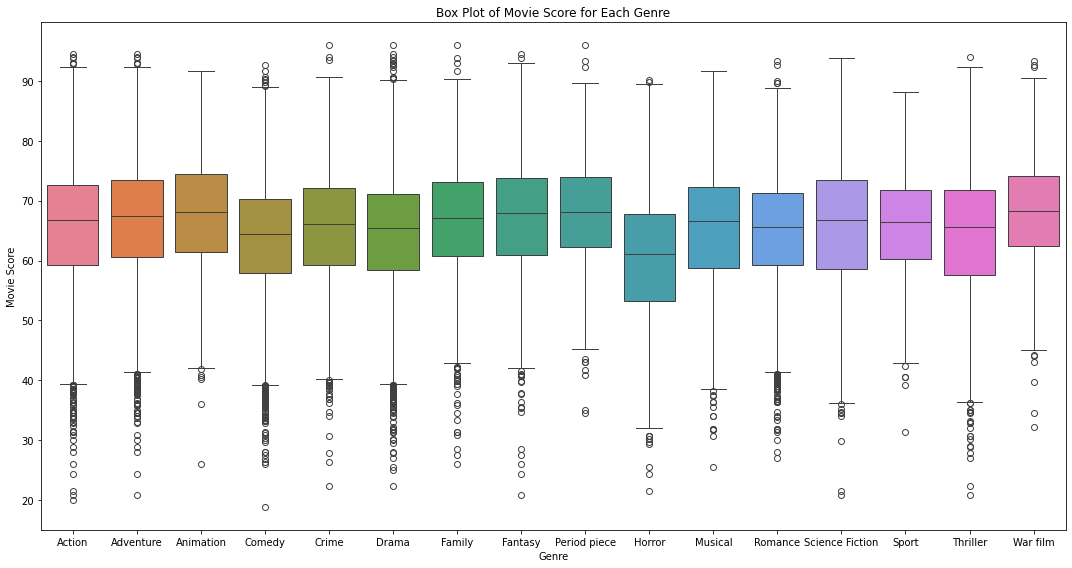

In [274]:
# Create a list to store DataFrames for box plots
boxplot_genre_dfs = []

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    # Use .copy() to create a copy and add a 'Genre' column
    genre_df_copy = genre_df.copy()
    genre_df_copy['Genre'] = genre
    boxplot_genre_dfs.append(genre_df_copy[['movie_score', 'Genre']])

# Concatenate the DataFrames along the rows for box plot
boxplot_concat = pd.concat(boxplot_genre_dfs)

# Create a box plot using Seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(x='Genre', y='movie_score', data=boxplot_concat, showfliers=True, hue='Genre')
plt.title('Box Plot of Movie Score for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Movie Score')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

We will now find some statistics for each genre

In [257]:
genre_stats = {}

for genre, genre_df in genre_dataframes.items():
    genre_stats[genre] = genre_df['movie_score'].describe()

print(genre_stats)

{'Action': count    3315.000000
mean       65.451447
std        10.737942
min        20.068884
25%        59.310175
50%        66.730583
75%        72.663039
max        94.563911
Name: movie_score, dtype: float64, 'Adventure': count    3248.000000
mean       66.526025
std        10.287417
min        20.918441
25%        60.519352
50%        67.447774
75%        73.383063
max        94.563911
Name: movie_score, dtype: float64, 'Animation': count    673.000000
mean      67.463643
std       10.178189
min       26.091910
25%       61.483851
50%       68.139762
75%       74.449975
max       91.640925
Name: movie_score, dtype: float64, 'Comedy': count    6489.000000
mean       63.719516
std         9.594062
min        18.884183
25%        57.840404
50%        64.465856
75%        70.306675
max        92.683054
Name: movie_score, dtype: float64, 'Crime': count    2783.000000
mean       65.224068
std         9.757997
min        22.265881
25%        59.295875
50%        66.026910
75%        72.

The above analysis was done considering all the movies in each genre. The results showed that despite Drama and Comedy being the more frequent / popular genres, they do not necessarily have the highest scores. To push our analysis further, we will compute the movie score statistics per genre and redo the box plot, but only for the movies in the top 20% percentile of each genre. 

In [258]:
genre_thresholds = {}
for genre, genre_df in genre_dataframes.items():
    percent_20_threshold = genre_df['movie_score'].quantile(0.8)
    genre_thresholds[genre] = percent_20_threshold

In [276]:
# Score statistics per genre
# Create empty dictionaries to store statistics for each genre
genre_stats_top_20 = {'Mean': {}, 'Median': {}}

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    
    percent_20_movies = genre_df[genre_df['movie_score'] >= genre_thresholds[genre]]

    mean_score = percent_20_movies['movie_score'].mean()
    median_score = percent_20_movies['movie_score'].median()
    #max_score = percent_20_movies['movie_score'].max()
    #min_score = percent_20_movies['movie_score'].min()

    # Store the results in the dictionaries
    genre_stats_top_20['Mean'][genre] = mean_score
    genre_stats_top_20['Median'][genre] = median_score
    #genre_stats['Maximum'][genre] = max_score
    #genre_stats['Minimum'][genre] = min_score

# For easy displays, convert the dictionaries to Pandas DataFrames 
mean_df = pd.DataFrame(genre_stats_top_20['Mean'], index=['Mean Movie Score'])
median_df = pd.DataFrame(genre_stats_top_20['Median'], index=['Median Movie Score'])
#max_df = pd.DataFrame(genre_stats['Maximum'], index=['Maximum Movie Score'])
#min_df = pd.DataFrame(genre_stats['Minimum'], index=['Minimum Movie Score'])

# Concatenate the DataFrames along the columns to create a general DataFrame
general_stats_df = pd.concat([mean_df, median_df])

# Display the summary DataFrame
general_stats_df.head(10)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Period piece,Horror,Musical,Romance,Science Fiction,Sport,Thriller,War film
Mean Movie Score,78.957673,79.755090,80.907175,76.207954,78.062116,77.283932,79.469923,80.811275,79.680787,74.882624,77.774218,76.725863,80.085396,77.687364,78.172573,80.344810
Median Movie Score,77.951128,78.565831,80.079709,75.294924,77.173120,76.254495,78.477625,79.696348,79.232729,73.620020,76.498839,75.716243,78.853480,77.589971,77.299869,79.548541


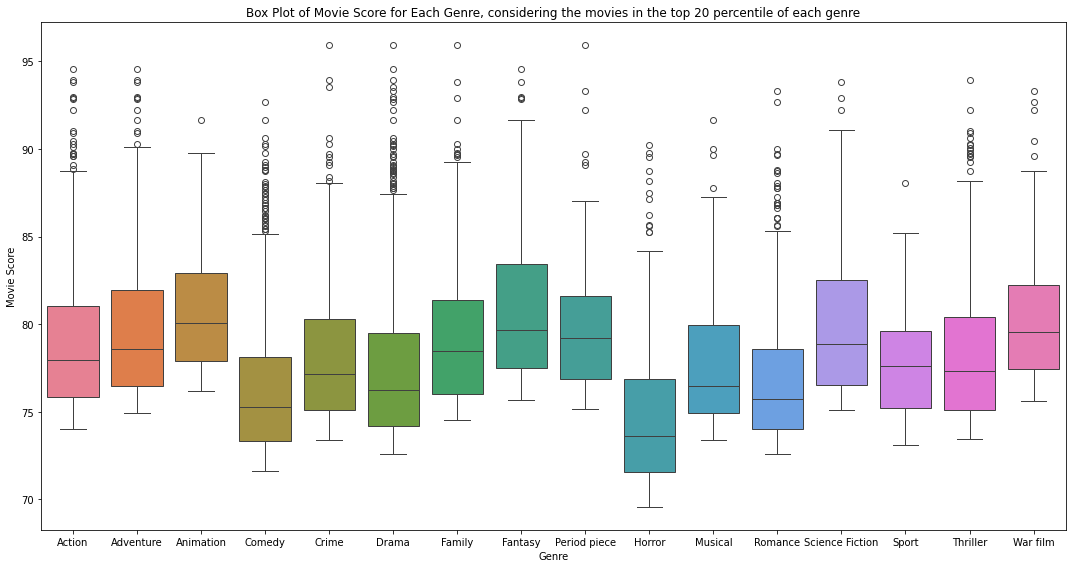

In [265]:
# Create a list to store DataFrames for box plots
boxplot_genres = []

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    top_20_movies = genre_df[genre_df['movie_score'] >= genre_thresholds[genre]]
    # Use .copy() to create a copy and add a 'Genre' column
    top_20_movies_copy = top_20_movies.copy()
    top_20_movies_copy['Genre'] = genre
    boxplot_genres.append(top_20_movies_copy[['movie_score', 'Genre']])

# Concatenate the DataFrames along the rows for box plot
boxplot_concat = pd.concat(boxplot_genres)

# Create a box plot using Seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(x='Genre', y='movie_score', data=boxplot_concat, showfliers=True, hue='Genre')
plt.title('Box Plot of Movie Score for Each Genre, considering the movies in the top 20 percentile of each genre')
plt.xlabel('Genre')
plt.ylabel('Movie Score')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

The statistics we obtained are different than when we considered all the movies for every genre. However, the genres do not vary that much in ranking, which is why we want to repeat the analysis again, but considering only the top 532 movies in terms of score for each genre. We chose 532 because the least frequent genre contains 532 movies. That way, we will be considering the same number of movies for all the genres. 

In [260]:
top_532_movies = {}
for genre, genre_df in genre_dataframes.items():
    sorted_genre = genre_df.sort_values(by='movie_score', ascending=False)
    top_532_genre = sorted_genre.head(532)
    top_532_movies[genre] = top_532_genre

In [277]:
# Score statistics per genre
# Create empty dictionaries to store statistics for each genre
genre_stats_top_532 = {'Mean': {}, 'Median': {}}

# Iterate through the genres and corresponding DataFrames
for genre, top_532_genre in top_532_movies.items():
    mean_score_top_532 = top_532_genre['movie_score'].mean()
    median_score_top_532 = top_532_genre['movie_score'].median()
    #max_score_top_532 = top_532_genre['movie_score'].max()
    #min_score_top_532 = top_532_genre['movie_score'].min()

    # Store the results in the dictionaries
    genre_stats_top_532['Mean'][genre] = mean_score_top_532
    genre_stats_top_532['Median'][genre] = median_score_top_532
    #genre_stats_top_532['Maximum'][genre] = max_score_top_532
    #genre_stats_top_532['Minimum'][genre] = min_score_top_532

# For easy displays, convert the dictionaries to Pandas DataFrames 
mean_df_top_532 = pd.DataFrame(genre_stats_top_532['Mean'], index=['Mean Movie Score'])
median_df_top_532 = pd.DataFrame(genre_stats_top_532['Median'], index=['Median Movie Score'])
#max_df_top_532 = pd.DataFrame(genre_stats_top_532['Maximum'], index=['Maximum Movie Score'])
#min_df_top_532 = pd.DataFrame(genre_stats_top_532['Minimum'], index=['Minimum Movie Score'])

# Concatenate the DataFrames along the columns to create a general DataFrame
general_stats_df_top_532 = pd.concat([mean_df_top_532, median_df_top_532])

# Display the summary DataFrame
general_stats_df_top_532.head(10)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Period piece,Horror,Musical,Romance,Science Fiction,Sport,Thriller,War film
Mean Movie Score,79.997909,80.708219,71.375025,79.799474,78.276996,82.653851,76.908974,75.842608,75.076743,71.256739,73.385569,78.231047,73.978356,65.649396,79.659462,72.693113
Median Movie Score,79.053346,79.792838,70.541793,78.956412,77.414410,81.807050,75.821870,74.478016,74.177187,70.231407,72.543353,77.239475,72.863872,66.479787,78.633254,71.494929


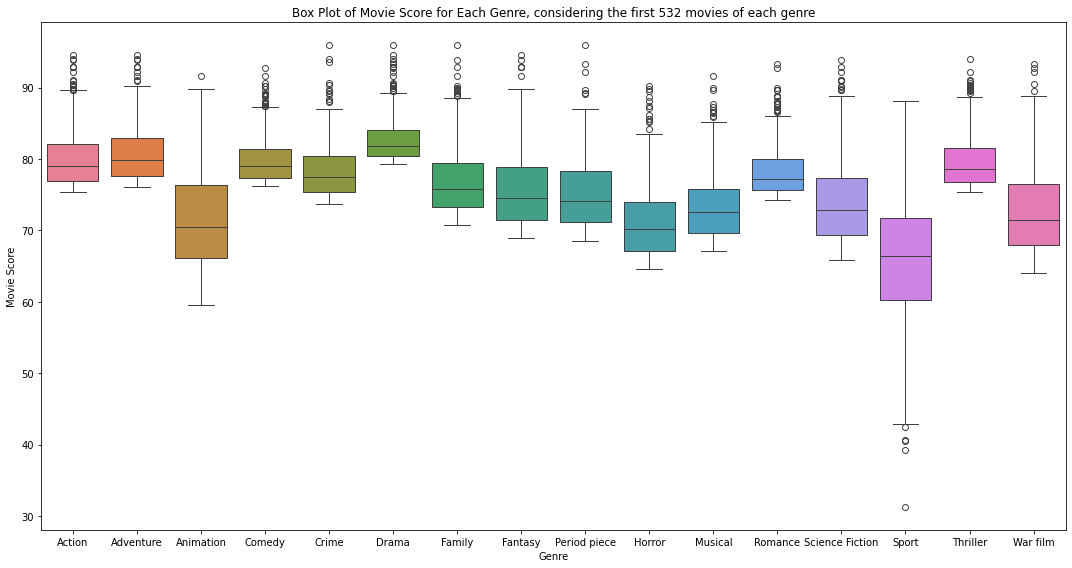

In [263]:
# Create a list to store DataFrames for box plots
boxplot_genres_top_532 = []

# Iterate through the genres and corresponding DataFrames
for genre, top_532_genre in top_532_movies.items():
    # Use .copy() to create a copy and add a 'Genre' column
    top_532_genre_copy = top_532_genre.copy()
    top_532_genre_copy['Genre'] = genre
    boxplot_genres_top_532.append(top_532_genre_copy[['movie_score', 'Genre']])

# Concatenate the DataFrames along the rows for box plot
boxplot_concat = pd.concat(boxplot_genres_top_532)

# Create a box plot using Seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(x='Genre', y='movie_score', data=boxplot_concat, showfliers=True, hue='Genre')
plt.title('Box Plot of Movie Score for Each Genre, considering the first 532 movies of each genre')
plt.xlabel('Genre')
plt.ylabel('Movie Score')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Inclusivity

Let’s begin by retrieving actors’ information’s.

In [ ]:
col_names = ['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'date_of_birth', 'gender', 'height', 'ethnicity_id', 'name', 'age_at_release', 'freebase_character_map_id', 'freebase_character_id', 'freebase_actor_id']

characters = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep='\t', header=None,  names=col_names)
characters.head()

In [ ]:
actors = characters[['date_of_birth',
    'gender',
    'height',
    'ethnicity_id',
    'name',
    'freebase_actor_id']]
non_duped_actors = actors.drop_duplicates()
non_duped_actors.head()

In [ ]:
#Remove actors with non given name
named_actors = non_duped_actors[~non_duped_actors['name'].isna() ]
named_actors.head()

To look at the data, we now find out the proportion of ethnicity ids presence between actors accros all films:

In [ ]:
actors_in_movie_eth = characters[['name','freebase_actor_id','wikipedia_movie_id','ethnicity_id']].drop_duplicates()
actors_in_movie_eth = actors_in_movie_eth[~actors_in_movie_eth['name'].isna()].drop(columns=['name'])
actors_in_movie_eth_counts = actors_in_movie_eth.groupby('freebase_actor_id').count().rename(columns = {'wikipedia_movie_id': 'Movie count', 'ethnicity_id': 'Number of Ethnicity tags'})
actors_in_movie_eth_counts = actors_in_movie_eth_counts[actors_in_movie_eth_counts['Movie count'] >= 1]
print(actors_in_movie_eth_counts[actors_in_movie_eth_counts['Number of Ethnicity tags']==0].sum())




In [ ]:
actors_with_eth_tags_count = actors_in_movie_eth_counts[actors_in_movie_eth_counts['Number of Ethnicity tags']!= 0]
print(actors_with_eth_tags_count.sum())


Below are all the actors with tags :

In [ ]:
actor_eth = characters[['name','freebase_actor_id','ethnicity_id']].drop_duplicates()
actor_eth = actor_eth[~actor_eth['name'].isna()].drop(columns=['name'])
actor_eth
actor_eth[~actor_eth['ethnicity_id'].isna()]

The below graphs shows the distribution of ethnicity tags and actors existance in film:

In [ ]:
actors_in_movie_eth = characters[['name','freebase_actor_id','wikipedia_movie_id','ethnicity_id']].drop_duplicates()
actors_in_movie_eth = actors_in_movie_eth[~actors_in_movie_eth['name'].isna()].drop(columns=['name'])
actors_in_movie_eth.groupby('wikipedia_movie_id').count().describe()
actors_in_movie_eth.groupby('wikipedia_movie_id').count().hist(bins=20, range = [0,5])


Below is the movie's distinctive ethnicity tag repartitions considering NaN values:    
Note that per movie we consider each actor once.

In [ ]:
eth_in_movie_eth = characters[['name','freebase_actor_id','wikipedia_movie_id','ethnicity_id']].drop_duplicates()
eth_in_movie_eth = eth_in_movie_eth[~eth_in_movie_eth['name'].isna()].drop(columns=['name', 'freebase_actor_id'])
eth_in_movie_eth = eth_in_movie_eth.drop_duplicates()
eth_in_movie_eth.groupby('wikipedia_movie_id').count().hist(bins=20, range = [0,5])

We start our study on ethnicity by selecting movies that had sufficient information about the ethnicity in their cast. This leads us to define a certain threshold on the number of actors' ethnicity tags per film, and only consider the movies that have a number of tags larger than this threshold.   
On these movies, we may now compute the number of different tags of each movie and plotting histograms of the new data.
The movies which have a number of different tags larger than our defined threshold are considered as inclusive movies, while the others are considered as non-inclusive.    
The value of the threshold may be adapted in the future to see how it affects the results.

In [ ]:
thresh = 3

In [ ]:
eth_in_movie_eth = characters[['name','freebase_actor_id','wikipedia_movie_id','ethnicity_id']].drop_duplicates()
eth_in_movie_eth = eth_in_movie_eth[~eth_in_movie_eth['name'].isna()].drop(columns=['name', 'freebase_actor_id'])

eth_in_movie_eth = eth_in_movie_eth[~eth_in_movie_eth['ethnicity_id'].isna()]
count_by_movie_id = eth_in_movie_eth.groupby('wikipedia_movie_id').count()

#Film with infos on 3 ethnicities
filtered_data = eth_in_movie_eth[eth_in_movie_eth['wikipedia_movie_id'].isin(count_by_movie_id[count_by_movie_id >= thresh].dropna().index)]
#Films with possible duplicates of these 3 ethnicities ie the movies for which we have sufficient data to determine whether they are inclusive or not.
filtered_data.groupby('wikipedia_movie_id').count().hist(bins=20, range = [0,thresh+3])

#Films with at least distinct 3 ethnicities among these movies for which we have sufficient data
filtered_data.drop_duplicates().groupby('wikipedia_movie_id').count().hist(bins=20, range = [0,thresh+3])

But before starting analysing the data, we need to match the given ethnicity ids with their respective values from freebase and wikidata      
Below is the scraping :

In [ ]:
eth_indexes = actors['ethnicity_id'].value_counts().index
eth_indexes

In [ ]:
actors['ethnicity_id'].isna().sum()

In [ ]:
actors[~actors['ethnicity_id'].isna()]

In [ ]:
import requests

def get_wikidata_id(freebase_id):
    """
    Function fetching from the wikidata_id of the given freebase_id
    """
    # Wikidata SPARQL endpoint
    endpoint_url = "https://query.wikidata.org/sparql"
    
    # SPARQL query to get the Wikidata ID using the Freebase ID
    query = f'''
    SELECT ?item WHERE {{
        ?item wdt:P646 "{freebase_id}".
    }}
    '''
    
    # Send the request to the endpoint
    response = requests.get(endpoint_url, params={'query': query, 'format': 'json'})
    while response.status_code == 429:
        time.sleep(2.5)
        print('sleeping')
        response = requests.get(endpoint_url, params={'query': query, 'format': 'json'})
        print('Woke up !')
    # Parse the response
    data = response.json()
    
    # Extract the Wikidata ID from the response
    results = data.get("results", {}).get("bindings", [])
    if results:
        wikidata_id = results[0].get("item", {}).get("value", "")
        # Extract the ID from the full URI
        wikidata_id = wikidata_id.split('/')[-1]
        return wikidata_id
    else:
        return None


In [ ]:
def get_ethnicity_info(wikidata_id):
    """
    Function fetching the ethnicity information using the wikidata_id
    """
    endpoint_url = "https://query.wikidata.org/sparql"
    query = f'''
    SELECT ?property ?propertyLabel ?value ?valueLabel WHERE {{
        wd:{wikidata_id} ?p ?statement .
        ?statement ?ps ?value .
        
        ?property wikibase:claim ?p.
        ?property wikibase:statementProperty ?ps.
        
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    ORDER BY ?property ?value
    '''
    
    # Send the request to the endpoint
    response = requests.get(endpoint_url, params={'query': query, 'format': 'json'})
    while response.status_code == 429:
        time.sleep(2.5)
        print('sleeping')
        response = requests.get(endpoint_url, params={'query': query, 'format': 'json'})
        print('Woke up !')
        
    # Parse the response
    data = response.json()
    # Process the data to extract labels and values
    properties = {}
    for item in data.get("results", {}).get("bindings", []):
        prop = item.get("propertyLabel", {}).get("value", "")
        val = item.get("valueLabel", {}).get("value", "")
        if prop and val:
            if prop in properties:
                properties[prop].append(val)
            else:
                properties[prop] = [val]
        
    return properties


In [ ]:
# Mock example :
freebase_id =  '/m/043_z22'
wikidata_id = get_wikidata_id(freebase_id)
print(wikidata_id)
if wikidata_id:
    ethnicity_info = get_ethnicity_info(wikidata_id)
    print(ethnicity_info['instance of'])
else:
    print("Wikidata ID not found for the given Freebase ID.")


In [ ]:
def scrape_ethnicity_infos(eth_indexes):
    """
    Function scraping for a list of ethnicity values using a list of ethnicity freebase id
    """
    free_ids = []
    wiki_ids = []
    eth_infos = []
    for idx, act_eth in enumerate(eth_indexes):
            if idx %10 == 0:
                print("Random sleep", idx)
                time.sleep(2.5)
                print('Woke up !')
                
            freebase_id =  act_eth
            wikidata_id = get_wikidata_id(freebase_id)
            
            free_ids.append(freebase_id)
            wiki_ids.append(wikidata_id)
            if wikidata_id:
                ethnicity_info = get_ethnicity_info(wikidata_id)
                eth_infos.append(ethnicity_info)
            else:
                eth_infos.append(None)
                print("Wikidata ID not found for the given Freebase ID.")
                
    return eth_infos, wiki_ids, free_ids

In [ ]:
def retrieve_ethnicity_infos(eth_indexes=None):
    """
    Function used to retrieve the ethnicity values either from saved data or from scraping
    """
    try:
        with open(ADDITIONAL_FOLDER + 'eth_infos.pkl', 'rb') as file:
            eth_infos = pkl.load(file)
        with open(ADDITIONAL_FOLDER + 'wiki_ids.pkl', 'rb') as file:
            wiki_ids = pkl.load(file)
        with open(ADDITIONAL_FOLDER + 'free_ids.pkl', 'rb') as file:
            free_ids = pkl.load(file)
        return eth_infos, wiki_ids, free_ids
    
    except:
        eth_infos, wiki_ids, free_ids = scrape_ethnicity_infos(eth_indexes)
        with open(ADDITIONAL_FOLDER + 'eth_infos.pkl', 'wb') as file:
            pkl.dump(eth_infos, file)      
        with open(ADDITIONAL_FOLDER + 'wiki_ids.pkl', 'wb') as file:
            pkl.dump(wiki_ids, file)   
        with open(ADDITIONAL_FOLDER + 'free_ids.pkl', 'wb') as file:
            pkl.dump(free_ids, file)
        return eth_infos, wiki_ids, free_ids      

In [ ]:
eth_infos, wiki_ids, free_ids = retrieve_ethnicity_infos(eth_indexes=eth_indexes)
len(eth_infos)

In [ ]:
data_dict = {
    'wiki_ids': wiki_ids,
    'eth_infos': eth_infos,
    'category' : np.nan
}

# Create a ethnicity information DataFrame with free_ids as the index
ethnicity_map = pd.DataFrame(data_dict, index=free_ids)
ethnicity_map['category'] = ethnicity_map['category'].astype('object')
ethnicity_map

In [ ]:
ethnicity_map = ethnicity_map.replace('', np.nan)
ethnicity_map = ethnicity_map[ (~ethnicity_map['eth_infos'].isna() )]

The best way to understand the data is to look at it.
In the following subsection we are going to retrieve little by little information from the quite dirty obtained data :

In [ ]:
ethnicity_map['eth_infos'].iloc[1]

In [ ]:
def remove_stopwords_and_specific_words(text, specific_words):
    """
    Function used to preprocess and clean the ethnicities values obtained by removing stop words and demanded words.
    """
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() not in specific_words]
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

In [ ]:
class EthnicityColumnProcessing(ABC):
    """
    Super class used to define a generic cleaning policy of the ethnicity values.
    """
    @staticmethod
    def find_category_from_dict(dico):
        """
        Function which return a single cleaned and demanded from a dict.
        """
        raise NotImplementedError("Subclasses must implement this method")
        
    @staticmethod
    def process_data_list(data_list):
        """
        Function used to clean the hole data obtained from the ethnicity dict.
        """
        if data_list is None or data_list is np.nan:
            return np.nan
            
        new_data_list = []  
        for item in data_list:
            processed_content = item.replace('-', ' ').lower()
            processed_content = remove_stopwords_and_specific_words(processed_content, ['people', 'peoples', 'descent'])
            new_data_list.append(processed_content)
        return new_data_list
        
    @classmethod
    def process_dataframe(cls, df):
        """
        Function used to obtain and update the ethnicity category of a dataframe with new informations.
        """
        for index, row in df.iterrows():
            if isinstance(row['category'], list):
                if pd.isna(row['category']).all():
                    df.at[index, 'category'] = cls.process_data_list(cls.find_category_from_dict(row['eth_infos']))
            elif pd.isna(row['category']):
                df.at[index, 'category'] = cls.process_data_list(cls.find_category_from_dict(row['eth_infos']))
        

We incrementally add values from the ethnicity infos `eth_info` to the ethnicity category of our dataframe `ethnicity_map`

In [ ]:
class MainCategoryProcessing(EthnicityColumnProcessing):
    @staticmethod
    def find_category_from_dict(dico):
        category = dico.get("topic's main category", np.nan)   
        return category
        
    @staticmethod
    def process_data_list(data_list):
        if data_list is None or data_list is np.nan:
            return np.nan
            
        new_data = []  
        for item in data_list:
            if item.startswith("Category:"):
                content = item[len("Category:"):]
    
                processed_content = content.replace('-', ' ').lower()
                processed_content = remove_stopwords_and_specific_words(processed_content, ['people', 'peoples', 'descent'])
                new_data.append(processed_content)
            else:
                continue
    
        return new_data

In [ ]:
MainCategoryProcessing().process_dataframe(ethnicity_map)
ethnicity_map

In [ ]:
ethnicity_map['eth_infos'].loc['/m/03x_fq7']

In [ ]:
class CommonCategoryProcessing(EthnicityColumnProcessing):
    @staticmethod
    def find_category_from_dict(dico):
        category = dico.get('Commons category', np.nan)   
        return category

CommonCategoryProcessing().process_dataframe(ethnicity_map)
display(ethnicity_map)
ethnicity_map.isna().sum()

In [ ]:
class EncyclopedyCategoryProcessing(EthnicityColumnProcessing):
    @staticmethod
    def find_category_from_dict(dico):
        if isinstance(dico, dict):
            eth = dico.get('Encyclopædia Britannica Online ID', np.nan)
            if eth is not np.nan:
                eth = eth[0].removeprefix("topic/")
                    
            return eth
        else: 
            return np.nan
        
EncyclopedyCategoryProcessing().process_dataframe(ethnicity_map)
ethnicity_map.isna().sum()

In [ ]:
ethnicity_map.loc['/m/06mvq'].eth_infos

In [ ]:
class QuoraCategoryProcessing(EthnicityColumnProcessing):
    @staticmethod
    def find_category_from_dict(dico):
        category = dico.get('Quora topic ID', np.nan)   
        return category
        
QuoraCategoryProcessing().process_dataframe(ethnicity_map)
ethnicity_map.isna().sum()

In [ ]:
ethnicity_map[(ethnicity_map['category'].isna())]

In [ ]:
ethnicity_map.loc['/m/0g96wd'].eth_infos

In [ ]:
ethnicity_map.loc['/m/02rm7_9'].eth_infos

In [ ]:
class CountryCategoryProcessing(EthnicityColumnProcessing):
    @staticmethod
    def find_category_from_dict(dico):
        category = dico.get('country', np.nan)   
        return category
        
CountryCategoryProcessing().process_dataframe(ethnicity_map)
ethnicity_map.isna().sum()

In [ ]:
ethnicity_map.loc['/m/01hm_'].eth_infos

In [ ]:
ethnicity_map.loc['/m/047q05d'].eth_infos

In [ ]:
ethnicity_map.loc['/m/03b_13l'].eth_infos


In [ ]:
ethnicity_map.loc['/m/0960kn'].eth_infos

We see now that most of the useful obtained values are in our dataframe.   
we therefore stop the incremental dataframe update here.   
We find now all actors with existing mapping:

In [ ]:
# All actors with existing mapping
useful_eth_tags = ethnicity_map[~ethnicity_map['category'].isna()]
useful_eth_tags

actors_with_eth_tags = characters[['name','freebase_actor_id','wikipedia_movie_id','ethnicity_id']].drop_duplicates()
actors_with_eth_tags = actors_with_eth_tags[~actors_with_eth_tags['name'].isna()].drop(columns=['name'])

actors_with_eth_tags = actors_with_eth_tags[~actors_with_eth_tags['ethnicity_id'].isna()]
actors_with_eth_categories = actors_with_eth_tags[actors_with_eth_tags['ethnicity_id'].isin(useful_eth_tags.index)]
actors_with_eth_categories

We now recompute the last cell to check if any drastic changes in the data occured 

In [ ]:
eth_in_movie_eth = actors_with_eth_categories.drop(columns=['freebase_actor_id'])

eth_in_movie_eth = eth_in_movie_eth[~eth_in_movie_eth['ethnicity_id'].isna()]
count_by_movie_id = eth_in_movie_eth.groupby('wikipedia_movie_id').count()

#Film with infos on 3 ethnicities
filtered_data = eth_in_movie_eth[eth_in_movie_eth['wikipedia_movie_id'].isin(count_by_movie_id[count_by_movie_id >= thresh].dropna().index)]

#Films with possible duplicates of these 3 ethnicities ie the movies for which we have sufficient data to determine whether they are inclusive or not.
filtered_data.groupby('wikipedia_movie_id').count().hist(bins=20, range = [0,thresh+3])

#Films with at least distinct 3 ethnicities among these movies for which we have sufficient data
filtered_data.drop_duplicates().groupby('wikipedia_movie_id').count().hist(bins=20, range = [0,thresh+3])



We saw that no drastic change occured except for some loss of movies.

Now let's start our little analysis by first redefining the choosen threshold for separating non inclusive and inclusive films :

In [ ]:
threshold = 3

In [ ]:
film_ethnicity_difference_repartition = filtered_data.drop_duplicates().groupby('wikipedia_movie_id').count()
low_inclusivity_films_ids = film_ethnicity_difference_repartition[film_ethnicity_difference_repartition < threshold].dropna().index
high_inclusivity_films_ids = film_ethnicity_difference_repartition[film_ethnicity_difference_repartition >= threshold].dropna().index

In [ ]:
movies_inclusivity = movies.copy(deep=True)

In [ ]:
low_inclusivity_movies = movies_inclusivity[movies_inclusivity['wikipedia_movie_id'].isin(low_inclusivity_films_ids)]
high_inclusivity_movies = movies_inclusivity[movies_inclusivity['wikipedia_movie_id'].isin(high_inclusivity_films_ids)]
display(low_inclusivity_movies)
display(high_inclusivity_movies)

In [ ]:
inclusive_good_movies = df_good_movies[df_good_movies['wikipedia_movie_id'].isin(high_inclusivity_films_ids)].copy(deep=True)
inclusive_bad_movies = df_bad_movies[df_bad_movies['wikipedia_movie_id'].isin(high_inclusivity_films_ids)].copy(deep=True)
exclusive_good_movies = df_good_movies[df_good_movies['wikipedia_movie_id'].isin(low_inclusivity_films_ids)].copy(deep=True)
exclusive_bad_movies = df_bad_movies[df_bad_movies['wikipedia_movie_id'].isin(low_inclusivity_films_ids)].copy(deep=True)

inc_good_len = len(inclusive_good_movies)
inc_bad_len = len(inclusive_bad_movies)
ex_good_len = len(exclusive_good_movies)
ex_bad_len = len(exclusive_bad_movies)


In [ ]:
print(f"Number of good inclusive movies {inc_good_len}")
print(f"Number of good exclusive movies {ex_good_len} ")
print()
print(f"Number of bad inclusive movies {inc_bad_len}")
print(f"Number of bad exclusive movies {ex_bad_len}")

With a naive and somewhat incorrect analysis, we see that inclusive movies tend to be worse than their counter parts, but somehow more rewarding 
when successful. 
A deeper probabilistic analysis is therefore needed here to know if there is a significant difference between inclusive and exclusive movies success 

As a first step in this direction, lets compute the proportion of inclusive and exclusive movies that are good.

In [ ]:
print(f"Proportion of inclusive movies that are good movies {inc_good_len / (inc_good_len + inc_bad_len)}")
print(f"Proportion of exclusive movies that are good movies {ex_good_len / (ex_good_len + ex_bad_len)}")

In [ ]:
exclusive_mean = low_inclusivity_movies["movie_score"].mean()
inclusive_mean = high_inclusivity_movies["movie_score"].mean()

ex_std = low_inclusivity_movies["movie_score"].std()
in_std = high_inclusivity_movies["movie_score"].std()

e_b = exclusive_mean - 1.96 * ex_std / np.sqrt(low_inclusivity_movies['movie_score'].shape[0])
e_u = exclusive_mean + 1.96 * ex_std / np.sqrt(low_inclusivity_movies['movie_score'].shape[0])

i_b = inclusive_mean - 1.96 * in_std / np.sqrt(high_inclusivity_movies['movie_score'].shape[0])
i_u = inclusive_mean + 1.96 * in_std / np.sqrt(high_inclusivity_movies['movie_score'].shape[0])

print(f"Exclusive movies' mean movie score 95% confidence interval: [{e_b:.4f}, {e_u:.4f}]")
print(f"Inclusive movies' mean movie score 95% confidence interval: [{i_b:.4f}, {i_u:.4f}]")

In [ ]:
#confid = df[~df["salary"].isna()][["salary", "throws"]]
inc = pd.DataFrame()
exl = pd.DataFrame()

inc['movie_score'] = high_inclusivity_movies["movie_score"]
exl['movie_score'] = low_inclusivity_movies["movie_score"]

inc['inclusivity'] = "Highly Inclusive"
exl['inclusivity'] = "Lowly Inclusive"

confid = pd.concat([inc, exl])
#display(confid)
sns.pointplot(x="inclusivity",
              y="movie_score",
              data=confid,
              errorbar=('ci', 95),
              n_boot=10000,
              seed=1,
              )
plt.title('Point plot showing confidence intervals of movie scores in function of inclusivity of the film')
plt.grid(False)
plt.show()


This simplistic analysis therefore shows that inclusive films somewhat performs better than non-inclusive one.
However some issues as data imbalance must be addressed further on.

We want to add the binary inclusivity feature to our movies dataframe.

In [ ]:
movies_with_inclusivity = movies.copy(deep=True)

movies_with_inclusivity["inclusivity"] = np.nan
movies_with_inclusivity.loc[movies_with_inclusivity["wikipedia_movie_id"].isin(low_inclusivity_films_ids), "inclusivity"] = 0
movies_with_inclusivity.loc[movies_with_inclusivity["wikipedia_movie_id"].isin(high_inclusivity_films_ids), "inclusivity"] = 1

In [ ]:
movies_with_inclusivity["inclusivity"].isna().value_counts()

In [ ]:
movies_with_inclusivity["inclusivity"].value_counts()

## Sequels

### Firstly We fetch Sequel Data

In [ ]:
# data comes from https://data.world/priyankad0993/sequels
df_sequels = pd.read_excel(ADDITIONAL_FOLDER + 'sequels.xlsx')[["Title", "Release Date", "Year", "IMDb Rating", "Runtime (mins)", "Genres", "Num Votes", "Directors", "Movie Series", "Order"]]#,
              #dtype={'Name': str, 'Value': float}) 

df_sequels["Genres"] = df_sequels["Genres"].apply(lambda x: x.split(", "))

In [ ]:
df_data = movies.copy(deep=True)
df_data.rename(columns={'name': 'movie_title', 'year': 'Year'}, inplace=True)
df_data.head()

In [ ]:
# we need the titles in lower case
df_sequels['Title'] = df_sequels['Title'].str.lower().str.replace('[^\w\s]','')
df_data['movie_title'] = df_data['movie_title'].str.lower().str.replace('[^\w\s]','')

### we only want to keep those for which we have data

In [ ]:
df_movie_series = df_sequels.merge(df_data, left_on=['Title', "Year"], right_on=['movie_title', "Year"], how='inner')

### Now that we have the sequels and prequels we need to preprocess the data

In [ ]:
df_movie_series.shape[0]

In [ ]:
df_movie_series.head()

In [ ]:
# we 
df_movie_series[~df_movie_series["adjusted_revenue"].isna()].shape[0]

### We remove movies where we don't have data for at least two of the series

Sometimes the sequel came after our dataset cutoff (November 2, 2012) so we don't have data for these

In [ ]:
# We dont keep movies with only one movie in that Movie Series
df_movie_series = df_movie_series.groupby('Movie Series').filter(lambda x: len(x) >= 2)
df_movie_series.shape[0]

In [ ]:
# Grouping by "Movie Series"
grouped = df_movie_series.groupby('Movie Series')

# Creating a DataFrame for prequels (movies with the minimum Order in each group)
prequels_df = df_movie_series[df_movie_series['Order'] == grouped['Order'].transform('min')]

# Creating a DataFrame for sequels (movies where Order is not the minimum in each group)
sequels_df = df_movie_series[df_movie_series['Order'] != grouped['Order'].transform('min')]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Creating a figure with two subplots
# Combine the data for both prequels and sequels to find the common y-axis limit
combined_data = pd.concat([prequels_df["movie_score"], sequels_df["movie_score"]])
y_max = combined_data.max()  # Find the maximum value to set the y-axis limit


# Plotting boxplot for prequels
axes[0].boxplot(prequels_df["movie_score"])
axes[0].set_title('Prequels Boxplot')
axes[0].set_ylabel('Movie Score (function of revenue and rating)')
axes[0].set_ylim(-2, y_max + 2) 

# Plotting boxplot for sequels
axes[1].boxplot(sequels_df["movie_score"])
axes[1].set_title('Sequels Boxplot')
axes[1].set_ylabel('Movie Score (function of revenue and rating)')
axes[1].set_ylim(-2, y_max + 2) 

plt.tight_layout()  # Adjust layout

In [ ]:
from scipy.stats import ttest_ind, shapiro, levene

prequel_scores = prequels_df["movie_score"]
sequel_scores = sequels_df["movie_score"]


# Check assumptions (normality and variance equality)
# Perform Shapiro-Wilk test for normality
shapiro_sequels = shapiro(prequel_scores)
shapiro_prequels = shapiro(sequel_scores)

print(shapiro_sequels)
print(shapiro_prequels)

# Perform Levene's test for equality of variances
levene_test = levene(sequel_scores, prequel_scores)
print(levene_test)

# Perform t-test
t_stat, p_value = ttest_ind(sequel_scores, prequel_scores, equal_var=True)  # Assuming equal variances

print(t_stat, " ", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject Null Hypothesis: Significant difference between sequel and prequel scores.")
else:
    print("Failed to reject Null Hypothesis: No significant difference between sequel and prequel scores.")

# the Shapiro-Wilk tests indicate non-normality, the Levene test suggests unequal variances, 
# and the t-test suggests a significant difference in the means of the two groups. 
# These results indicate that assumptions for a t-test might not hold, and alternative approaches 
# might be necessary to compare the means of the two groups.

### We look at the differences in scores between the prequel and corresponding sequels to see if in general it increases or decreases

In [ ]:
# Create a dictionary mapping prequel scores to their series
prequel_scores_dict = prequels_df.set_index('Movie Series')['movie_score'].to_dict()

# Function to calculate the score difference based on the series
def score_difference(row):
    prequel_score = prequel_scores_dict.get(row['Movie Series'], None)
    if prequel_score is not None:
        return row['movie_score'] - prequel_score
    else:
        return None

# Apply the function to create a new column 'Score Difference'
sequels_df['Score Difference'] = sequels_df.apply(score_difference, axis=1)

In [ ]:
sequels_df["Score Difference"].hist()

#### Clearly in general, sequels are worst, but we'd like to see if the movies that did improve have something in common.
#### In other words we are searching for a positive change from prequel to sequels

In [ ]:
sequels_that_improved = sequels_df[sequels_df["Score Difference"] >= 0][["Title", "Release Date","IMDb Rating", "Genres", "adjusted_revenue", "movie_score", "Score Difference", "Good Movie"]]
sequels_that_worstened = sequels_df[sequels_df["Score Difference"] < 0][["Title", "Release Date","IMDb Rating", "Genres", "adjusted_revenue", "movie_score", "Score Difference", "Good Movie"]]
sequels_that_improved.head()

We can see that most of these movies are Categorized as Good Movies. Lets dig deeper

In [ ]:
# Creating pie charts for 'Good Movie' column in prequels and sequels DataFrames
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Choose contrasting shades within the 'vlag' palette
colors = [sns.color_palette('vlag')[0], sns.color_palette('vlag')[-1]]

keys = ["Bad Movies", "Good Movies"]
prequel_counts = prequels_df["Good Movie"].value_counts()
sequel_counts = sequels_df["Good Movie"].value_counts()

# declaring exploding pie 
explode = [0.1, 0] 
# define Seaborn color palette to use
  
# plotting prequel Good Movie share
axs[0].pie([prequel_counts[0], prequel_counts[1]], labels=keys, colors=colors, 
        explode=explode, autopct='%.0f%%') 
axs[0].set_title("Prequel share of Good and Bad Movies")

# Sequels
axs[1].pie([sequel_counts[0], sequel_counts[1]], labels=keys, colors=colors, 
        explode=explode, autopct='%.0f%%') 
axs[1].set_title("Sequel share of Good and Bad Movies")
plt.tight_layout()

### Analysis
We can see that more sequels are bad movies than good movies, eventhough the opposite is true for the prequels. In fact we saw that most sequels worsten in Movie Score. Yet there is still a non negligeable amount of good movies.

Maybe sequels are a safe way of surfing the popularity of a previous movie; however, they don't usually result in increased popularity.

In addition, it makes sense that a fewer prequels are Bad Movies, because it is very risky to tackle an unsuccessful movie

### Can we find a trend in the sequels that improved?

#### Lets see if we can find one among the Genres

In [ ]:
# Explode the lists in the 'genres' column
exploded_genres = sequels_that_improved.explode('Genres')

# Get the count of each genre
genre_counts = exploded_genres['Genres'].value_counts()
genre_counts

In [ ]:
# Explode the lists in the 'genres' column
exploded_genres = sequels_that_worstened.explode('Genres')

# Get the count of each genre
genre_counts = exploded_genres['Genres'].value_counts()
genre_counts

Can't see any significant differences (note that there are more sequels that worstened which explains the differences in counts) and the data is too sparse to try and find slight distinctions between the two sets.

Deeper analysis will be performed in P3

## Actors' popularity

First we need to read the actors dataset.

In [ ]:
characters_columns = ['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'actor_dob',
                      'gender',
                      'height', 'ethnicity', 'actor_name', 'actor_age_at_release', 'freebase_character_map', '0', '1']

characters = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep='\t', header=None, names=characters_columns,
                         usecols=['wikipedia_movie_id', 'actor_dob', 'actor_name', 'character_name', 'release_date'])
characters.head()

In [ ]:
movies_actors = movies.copy(deep=True)
movies_actors.head()

We don't need all the columns of movies dataset for this analysis.

In [ ]:
movies_actors = movies_actors[
    ['wikipedia_movie_id', 'name', 'release_date', 'movie_score', 'adjusted_revenue', 'genres', 'year']]
movies_actors.rename(columns={'genres': 'movie_genres', 'name': 'movie_title'}, inplace=True)
movies_actors.head()

Filtering the actors dataset to only contain actors of the movies left after preprocessing.

In [ ]:
print('Number of actors before filtering: ', characters.shape[0])
characters_relevant = characters[characters['wikipedia_movie_id'].isin(movies_actors['wikipedia_movie_id'])]
characters_relevant = characters_relevant[~characters_relevant['actor_name'].isna()]
print('Number of actors after filtering: ', characters_relevant.shape[0])

We want to define actor's popularity at the time of the movie release. For this reason we want to sum `movie_score` of movies released on previous years for which actor was part of the cast.

In [ ]:
def get_actors_popularity(movies_data, char_data, lookback_movies=-1):
    """
    The function computes the popularity of the actors in the movies they have played in.
    
    movies_data: dataframe containing movies data
    char_data: dataframe containing characters data
    lookback_movies: number of movies to consider for the popularity of the actor
    
    returns: dataframe containing actors popularity
    """
    popularity = []

    movies_data.sort_values(by=['year'], inplace=True)

    for i, movie in tqdm(movies_data.iterrows(), total=movies_data.shape[0]):
        actors = char_data[char_data['wikipedia_movie_id'] == movie['wikipedia_movie_id']]
        for j, actor in actors.iterrows():
            actor_name = actor['actor_name']

            relevant_movies = char_data[char_data['actor_name'] == actor_name]['wikipedia_movie_id']
            actor_movies = movies_data[movies_data['wikipedia_movie_id'].isin(relevant_movies)]

            if lookback_movies > 0:
                actor_movies = actor_movies[actor_movies['year'] < movie['year']][-lookback_movies:]
            else:
                actor_movies = actor_movies[actor_movies['year'] < movie['year']]

            popularity.append({'actor_name': actor_name, 'actor_popularity': actor_movies['movie_score'].sum(),
                               'year': movie['year'], 'character_name': actor['character_name'],
                               'movie_title': movie['movie_title'],
                               'wikipedia_movie_id': movie['wikipedia_movie_id'],
                               'movie_score': movie['movie_score']})

    return pd.DataFrame(popularity)

#### Popularity of the actors in all the previous movies they have played in
Here we are taking into account all the movies the actor has played in before the movie we are considering.

In [ ]:
try:
    actors_popularity = pd.read_csv(ADDITIONAL_FOLDER + 'actors_popularity.csv')
except:
    actors_popularity = get_actors_popularity(movies_actors, characters_relevant)
    actors_popularity.to_csv(ADDITIONAL_FOLDER + 'actors_popularity.csv', index=False)

In [ ]:
actors_popularity.sort_values(['actor_name', 'year'])

In [ ]:
grouped_popularity = actors_popularity.groupby(['movie_title', 'movie_score']).agg(
    sum_pop=('actor_popularity', 'sum')
).reset_index()
grouped_popularity.head()

In [ ]:
stats.pearsonr(grouped_popularity['movie_score'], grouped_popularity['sum_pop'])

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.19` which indicates a weak positive correlation between `sum_pop` of a movie and its `movie_score`

#### Popularity of the actors in the last 5 movies they have played in
Here we are taking into account only the last 5 movies the actor has played in before the movie we are considering.

In [ ]:
try:
    actors_popularity = pd.read_csv(ADDITIONAL_FOLDER + 'actors_popularity_5.csv')
except:
    actors_popularity = get_actors_popularity(movies_actors, characters_relevant, 5)
    actors_popularity.to_csv(ADDITIONAL_FOLDER + 'actors_popularity_5.csv', index=False)

grouped_popularity = actors_popularity.groupby(['movie_title', 'movie_score']).agg(
    sum_pop=('actor_popularity', 'sum')
).reset_index()

In [ ]:
stats.pearsonr(grouped_popularity['movie_score'], grouped_popularity['sum_pop'])

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.25` which indicates a weak positive correlation between `sum_pop` of a movie and its `movie_score`

#### Popularity of actors vs movie score for different genres

We want to see if the correlation between the popularity of actors and the movie score is different for different genres.

In [ ]:
popular_actors_by_genres = movies_actors.copy(deep=True)

First we need to separate genres for each movie making them separate rows.

In [ ]:
movie_genres = pd.DataFrame(columns=["wikipedia_movie_id", "genre_id"])
genre_dictionary = {}
for i in range(popular_actors_by_genres.shape[0]):
    wiki_id = popular_actors_by_genres["wikipedia_movie_id"].iloc[i]
    dico = ast.literal_eval(popular_actors_by_genres["movie_genres"][i])
    data = [{'wikipedia_movie_id': wiki_id, 'genre_id': key} for key in dico.keys()]
    dataframe = pd.DataFrame(data)
    movie_genres = pd.concat([movie_genres, dataframe], axis=0)
    genre_dictionary.update(dico)

movie_genres.head()

Here is the list of all the genres.

In [ ]:
genre_dictionary.values()

Let's plot the number of movies per genre.

In [ ]:
plt.figure(figsize=(20, 10))
values = movie_genres['genre_id'].value_counts()
values.rename(index=genre_dictionary, inplace=True)
values[:50].plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre for 50 genres', fontsize=20)
plt.show()

As we can see there are some genres with a very small number of movies. We will remove them.

In [ ]:
considered_number_of_movies = 500

reduced_movie_genres = movie_genres.groupby('genre_id').filter(lambda x: len(x) > considered_number_of_movies).copy(
    deep=True)
reduced_genre_dictionary = {key: value for key, value in genre_dictionary.items() if
                            key in reduced_movie_genres['genre_id'].unique()}

In [ ]:
reduced_genre_dictionary.values()

In [ ]:
try:
    actors_popularity = pd.read_csv(ADDITIONAL_FOLDER + 'actors_popularity.csv')
except:
    actors_popularity = get_actors_popularity(movies_actors, characters_relevant)
    actors_popularity.to_csv(ADDITIONAL_FOLDER + 'actors_popularity.csv', index=False)

actors_popularity.head()

We need to separate different genres into different datasets and merge them with actors popularity.

In [ ]:
datasets_by_genres = []

for genre in reduced_genre_dictionary:
    genre_movies = reduced_movie_genres[reduced_movie_genres['genre_id'] == genre]
    genre_movies = pd.merge(genre_movies, actors_popularity, on='wikipedia_movie_id')
    datasets_by_genres.append(genre_movies)

In [ ]:
grouped_datasets_by_genres = []

for df in datasets_by_genres:
    grouped_popularity = df.groupby(['movie_title', 'movie_score', 'genre_id']).agg(
        sum_pop=('actor_popularity', 'sum')
    ).reset_index()
    grouped_datasets_by_genres.append(grouped_popularity)

Let's see the correlation between the popularity of actors and the movie score for each genre.

In [ ]:
print('Correlation between sum of actor popularity and movie score for:\n')

correlations = []

for df in grouped_datasets_by_genres:
    correlations.append({'genre': reduced_genre_dictionary[df['genre_id'].iloc[0]],
                         'corr': stats.pearsonr(df['movie_score'], df['sum_pop'])})

correlations.sort(key=lambda x: x['corr'][0], reverse=True)

for stat in correlations:
    print(stat['genre'], ': ', stat['corr'][0])

We can see that the correlation is different for different genres. We will plot the correlation for each genre.

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar([stat['genre'] for stat in correlations], [stat['corr'][0] for stat in correlations])
plt.xlabel('Genre')
plt.ylabel('Correlation')
plt.title('Correlation between sum of actor popularity and movie score for each genre', fontsize=20)
plt.xticks(rotation=90)
plt.show()

## Movie producers' popularity

We want to define producer's popularity at the time of the movie release. For this reason we want to sum `movie_score` of movies released on previous years for which the same person was a director.

In [ ]:
movies_producers = movies.copy(deep=True)
movies_producers.head()

In [ ]:
def get_producers_popularity(movies_data, lookback_movies=-1):
    """
    The function computes the popularity of the producers in the movies they have produced.
    
    movies_data: dataframe containing movies data
    lookback_movies: number of movies to consider for the popularity of the producer
    
    returns: dataframe containing producers popularity
    """
    
    popularity = []

    movies_data.sort_values(by=['year'], inplace=True)

    for i, movie in tqdm(movies_data.iterrows(), total=movies_data.shape[0]):
        producer = movie['producer']
        relevant_movies = movies_data[movies_data['producer'] == producer]

        if lookback_movies > 0:
            producer_movies = relevant_movies[relevant_movies['year'] < movie['year']][-lookback_movies:]
        else:
            producer_movies = relevant_movies[relevant_movies['year'] < movie['year']]

        popularity.append({'producer': producer, 'producer_popularity': producer_movies['movie_score'].sum(),
                           'year': movie['year'],
                           'movie_title': movie['name'],
                           'wikipedia_movie_id': movie['wikipedia_movie_id'],
                           'movie_score': movie['movie_score']})

    return pd.DataFrame(popularity)

#### Popularity of the producers in all the previous movies they have played in
Here we are taking into account all the movies the producer has produced before the movie we are considering.

In [ ]:
try:
    producers_popularity = pd.read_csv(ADDITIONAL_FOLDER + 'producers_popularity.csv')
except:
    producers_popularity = get_producers_popularity(movies_producers)
    producers_popularity.to_csv(ADDITIONAL_FOLDER + 'producers_popularity.csv', index=False)

In [ ]:
producers_popularity.sort_values(['producer', 'year'])

In [ ]:
stats.pearsonr(producers_popularity['movie_score'], producers_popularity['producer_popularity'])

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.24` which indicates a weak positive correlation between `producer_popularity` of a movie and its `movie_score`

## Sentiment analysis of movies endings (IN MILESTONE 3)

## First regression analysis

Let's run a simple regression analysis to see if we can predict the movie score from the data we have.

In [ ]:
# the dataset we are going to use for the regression analysis
movies_reg = movies_with_inclusivity.copy(deep=True)
movies_reg.drop(columns=["freebase_movie_id", "release_date", "revenue", "correlation_factor", "RC", "BORC", "budget", "gross_domestic", "opening_weekend", "rating_score"], inplace=True)

In [ ]:
regression_ids = movies_reg["wikipedia_movie_id"]

In [ ]:
movies_reg.head(3)

In [ ]:
try:
    movie_countries     = pd.read_csv(processed_directory + "/movie_countries.csv")
    country_dictionary  = pkl.load(open(processed_directory + "/country_dictionary.pickle", "rb"))
    movie_languages     = pd.read_csv(processed_directory + "/movie_languages.csv")
    language_dictionary = pkl.load(open(processed_directory + "/language_dictionary.pickle", "rb"))
    movie_genres        = pd.read_csv(processed_directory + "/movie_genres.csv")
    genre_dictionary   = pkl.load(open(processed_directory + "/genre_dictionary.pickle", "rb"))
except:
    raise ValueError("A file is missing, please run the previous parts of the notebook")

In [ ]:
grouped_by_genre = movie_genres.groupby(by="genre_id").count().dropna()

# select the movie genres for which there are at least `genre_threshold` movies of that genre
genre_threshold = 250
grouped_by_genre_filtered = grouped_by_genre[grouped_by_genre["wikipedia_movie_id"] > genre_threshold]
grouped_by_genre_filtered.shape
kept_genre_ids = grouped_by_genre_filtered.index
print(f"Number of genres kept:      {kept_genre_ids.shape[0]}")

# select the movie genres for which there are at least `language_threshold` movies of that language
language_threshold = 50
grouped_by_language = movie_languages.groupby(by="language_id").count().dropna()
grouped_by_language_filtered = grouped_by_language[grouped_by_language["wikipedia_movie_id"] > language_threshold]
kept_languages_ids = grouped_by_language_filtered.index
print(f"Number of languages kept:   {kept_languages_ids.shape[0]}")

# select the movie countries for which there are at least `country_threshold` movies of that country
country_threshold = 100
grouped_by_country = movie_countries.groupby(by="country_id").count().dropna()
grouped_by_country_filtered = grouped_by_country[grouped_by_country["wikipedia_movie_id"] > country_threshold]
kept_country_ids = grouped_by_country_filtered.index
print(f"Number of countries kept:   {kept_country_ids.shape[0]}")

In [ ]:
%%capture

kept_genre_names = [genre_dictionary[genre_id] for genre_id in kept_genre_ids]
kept_language_names = [language_dictionary[language_id] for language_id in kept_languages_ids]
kept_country_names = [country_dictionary[country_id] for country_id in kept_country_ids]
new_categorical_features = kept_genre_names + kept_language_names + kept_country_names

# creating empty binary features
movies_reg[kept_genre_names]    = np.nan
movies_reg[kept_language_names] = np.nan
movies_reg[kept_country_names]  = np.nan

In [ ]:
movies_reg.head(3)

We now need to fill the binary features with 1 if the movie has the corresponding genre/language/country and 0 otherwise.

In [ ]:
for index in tqdm(range(movies_reg.shape[0])):
    movie_languages = movies_reg.loc[index, "languages"]
    movie_genres    = movies_reg.loc[index, "genres"]
    movie_countries = movies_reg.loc[index, "countries"]

    language_dic  = ast.literal_eval(movie_languages)
    genre_dic     = ast.literal_eval(movie_genres)
    country_dic   = ast.literal_eval(movie_countries)

    for language in language_dic.values():
        if language in kept_language_names:
            movies_reg.loc[index, language] = 1

    for genre in genre_dic.values():
        if genre in kept_genre_names:
            movies_reg.loc[index, genre] = 1
            
    for country in country_dic.values():
        if country in kept_country_names:
            movies_reg.loc[index, country] = 1

In [ ]:
# removing features with only nans
movies_reg.dropna(inplace=True, axis=1, how='all')

# filling nan values by 0 for the new categorical features
movies_reg[new_categorical_features] = movies_reg[new_categorical_features].fillna(0)

movies_reg.head(3)

In [ ]:
movies_reg.head(1).columns.values

We drop the features that are not useful for the regression analysis.

In [ ]:
regression_data = movies_reg.drop(columns=["wikipedia_movie_id", "name", "languages", "countries",
                                            "genres", "producer", "adjusted_revenue", "Good Movie",
                                            "number_of_ratings", "watched_rank","adjusted_gross_domestic",
                                            "adjusted_opening_weekend"])

In [ ]:
from sklearn.model_selection import train_test_split

We split the data into train and test sets.

In [ ]:
np.random.seed(270)

# Split the data into train and test sets
train_data, test_data = train_test_split(regression_data, test_size=0.2, random_state=270)
x_train_raw, y_train_raw = train_data.loc[:, train_data.columns != "movie_score"], train_data["movie_score"]
x_test_raw, y_test_raw = test_data.loc[:, test_data.columns != "movie_score"], test_data["movie_score"]

x_train_raw.head(3)

We need to fill the missing values in the data.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# replacing missing values by the mean of the feature
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(x_train_raw)
x_train = imputer.transform(x_train_raw)
x_test  = imputer.transform(x_test_raw)

# scaling the data
scaler  = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

y_train = y_train_raw
y_test  = y_test_raw

We now have our data ready for the regression analysis.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_model = LinearRegression()

linear_model.fit(x_train, y_train)

y_pred = linear_model.predict(x_test)

print('Coefficients: \n', linear_model.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


plt.scatter(y_test, y_pred,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())
plt.xlabel("True movie score")
plt.ylabel("Predicted movie score")
plt.title("Linear regression model")
plt.show()

Let's see the most important features according to the linear regression model.

In [ ]:
feature_names = x_train_raw.columns.values
coef = linear_model.coef_
indices = np.argsort(coef)[::-1]

print("Top 20 features:")
for f in range(len(indices)):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], coef[indices[f]]))

In [ ]:
feature_names

From this simple model it turned out that the most important features are languages, countries and genres.

**We will do further analysis in Milestone 3.**